# Sentiment Analysis

Sentiment analysis of reviews in the dataset. Multiple methods were explored to scsore the review in a way similar to how a human might do it.

### 4 methods of aggregation were explored:
      
1. By sentences
    - Break reviews into sentences (SpaCy)
    - Get dominant topic for each sentence
    - Score sentiment for each sentence
    - Aggregate by scores for all reviews by topic then by sentiment type </br></br>
    
2. By review
    - Score sentiment on the whole review
    - Aggregate by topic then by sentiment type 
        - Positive, neutral, negative </br></br>

3. By sentence topics within each review
    - Break reviews into sentences (SpaCy)
    - Get dominant topic for each sentence
    - Score sentiment for each sentence
    - Group sentences and their sentiment scores by topic, for each review
    - Aggregate scores for all reviews by topic then by sentiment type </br></br>
    
4. By "paragraphs" within each review   <span style = "color:blue">(Final chosen method)</span>
    - Break reviews into "paragraphs" (Syntok; explained below)
    - Get dominant topic for each "paragraph"
    - Score sentiment for each "paragraph"
    - Get dominant topic for each "paragraph"
    - Group "paragraphs" and sentiment scores by topic, for each review 
    - Aggregate scores for all reviews by topic then by sentiment type

In [1]:
import bbcode
import re
import string
import spacy
from spacy.tokenizer import Tokenizer
import json

import nltk
from nltk import WordNetLemmatizer

import gensim
from gensim.models import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
from gensim.test.utils import datapath
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, LdaModel, LdaMulticore

import syntok.segmenter as segmenter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

unable to import 'smart_open.gcs', disabling that module
C:\Users\Henry\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#load dataset

final_data = pd.read_csv('./dataframes/dominant_topics.csv',index_col=0)

In [3]:
final_data.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
0,Online Mode,"Online review only...Simply put, it sucks ass....",0.6938,"['review', 'ass', 'minute', 'camp', 'bug', 'mo...",18,"['hell', 'lose', 'completion', 'gold_bars', 'g...",18,"mission, player, server, bug, rockstar, money,..."
1,Gaming Experience,It's a wonderful multiplayer and singleplayer ...,0.4671,"['connection_issues', 'friend']",2,"['friend', 'connection_issues']",2,"story, graphic, rockstar, character, experienc..."
2,Bugs & Issues,People claim a lot in reviews that they cant r...,0.5045,"['people', 'review', 'works_fine', 'pc', 'spec...",11,"['60_hours', 'need', 'works_fine', 'review', '...",11,"pc, crash, issue, problem, setting, steam, roc..."
3,Gaming Experience,"Best fucking story I have ever played, online'...",0.6944,['story'],1,['story'],1,"story, graphic, rockstar, character, experienc..."
4,Gaming Experience,well made game lots of fun,0.6944,['lots_fun'],1,['lots_fun'],1,"story, graphic, rockstar, character, experienc..."


In [6]:
len(final_data)

4836

# Method 1

1. By sentences
    - Break reviews into sentences (SpaCy)
    - Get dominant topic for each sentence
    - Score sentiment for each sentence
    - Aggregate by scores for all reviews by topic then by sentiment type </br></br>
    


### Preprocessing

In [8]:
#initialise BBcode parser and spacy NLP for parsing and tokenising sentences

nlp = spacy.load("en_core_web_sm")
parser = bbcode.Parser()

def parse(review):
    parsed_text = parser.strip(review)
    return parsed_text

#open pre-defined dictionary of english contractions, saved separately to avoid clutter (long dictionary, can be loaded as dict using json package)
with open('./en_contractions/contra_dict.txt') as contra_dict:
    cList = json.load(contra_dict)

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text.lower())

In [9]:
#Test NLP sentence tokeniser on one review

#generate test list of documents (just testing on 1 first to reduce clutter)
test_lst = [parse(x) for x in list(final_data['original_text'][:1])]

# credit to https://medium.com/@makcedward/nlp-pipeline-sentence-tokenization-part-6-86ed55b185e6 for the code below, which I modified for my use
for review in test_lst:
    print('Original Review: %s' % (review))
    print()
    doc = nlp(review)
    for i, sent in enumerate(doc.sents):
        print('-->Sentence %d: %s' % (i, sent.text))

Original Review: Online review only...Simply put, it sucks ass...Glitches every other minute camps always bugged out. Bounty will bug out and not give exp or money. you. Infinite loading screens after you do missions or anything that requires loading  causing you to lose the exp and or cash you would have got from completion. Gold bars are over priced as hell and RS makes it a slow crappy process to get gold even without all the glitching.... With glitches its just a  never ending grind. Maybe the story is good but the online is frustrating to say the least.

-->Sentence 0: Online review only...
-->Sentence 1: Simply put, it sucks ass...
-->Sentence 2: Glitches every other minute camps always bugged out.
-->Sentence 3: Bounty will bug out and not give exp or money.
-->Sentence 4: you.
-->Sentence 5: Infinite loading screens after you do missions or anything that requires loading  causing you to lose the exp and or cash you would have got from completion.
-->Sentence 6: Gold bars are ov

In [10]:
def parse_sent_tokenize(review):
    
    sent_tokens = [] #store sentence tokens here
    
    text = parse(review)  #remove BBcode first
    
    text = expandContractions(text)
    
    #All word lengths should be >1 character and <= length of the longest word in the English language. It's common for people spam incoherent letters on the Internet. Do not remove stopwords yet.
    text = [word for word in text.split() if len(word)>1 and len(word) <= len('pneumonoultramicroscopicsilicovolcanoconiosis')] 
   
    parsed_text = ' '.join(word for word in text)
    
    doc = nlp(parsed_text)
    for i,sent in enumerate(doc.sents):
        sent_tokens.append(sent.text)
    
    return sent_tokens

In [11]:
#test parse_sent_tokenize function
test_sents = parse_sent_tokenize(final_data['original_text'][0])
test_sents[:10]

['online review only...',
 'simply put, it sucks ass...glitches every other minute camps always bugged out.',
 'bounty will bug out and not give exp or money.',
 'you.',
 'infinite loading screens after you do missions or anything that requires loading causing you to lose the exp and or cash you would have got from completion.',
 'gold bars are over priced as hell and rs makes it slow crappy process to get gold even without all the glitching....',
 'with glitches its just never ending grind.',
 'maybe the story is good but the online is frustrating to say the least.']

In [12]:
#remove punctuation
def remove_punc(sents):
    clean_text = [s.translate(str.maketrans('', '', string.punctuation)) 
                  for s in sents]
    return clean_text

In [13]:
big_sent_lst =[] #For storing ALL sentences in the dataset. Doesn't matter which reviews they came from
sent_df = pd.DataFrame() #For visualisation of sentence transformations and saving of data

for review in final_data['original_text']:
    sent_tokens = parse_sent_tokenize(review)
    sent_tokens = remove_punc(sent_tokens)
    big_sent_lst.extend(sent_tokens)

In [14]:
sent_df['original_text'] = [x for x in big_sent_lst]
sent_df['token_sentences'] = [x.split() for x in big_sent_lst]
sent_df.head()

,original_text,token_sentences
0,online review only,"[online, review, only]"
1,simply put it sucks assglitches every other mi...,"[simply, put, it, sucks, assglitches, every, o..."
2,bounty will bug out and not give exp or money,"[bounty, will, bug, out, and, not, give, exp, ..."
3,you,[you]
4,infinite loading screens after you do missions...,"[infinite, loading, screens, after, you, do, m..."


In [15]:
#This output looks ready for tokenisation into a model-readable format. 
#The single numbers and overly short sentences will likely result in 0 to 1 tokens, which will be dropped later as established in the Model Validation notebook.

num_dict = {'0':'zero',
            '1':'one',
            '2':'two',
            '3':'three',
            #'i':'one',      skipped. Using Roman numeral 'i' will conflict with the pronoun "I", which is not a number
            'ii':'two',
            'iii':'three'   
            }

def num2word(d):
    
    if (len(d) == 1 and d in '0123')  or (d in ['ii','iii']):
        word = num_dict[d]
    
    elif (len(str(d))==1 and str(d) in '0123'):
        word = num_dict(str(d))
    
    else:
        word = d
    
    return word

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]

def remove_stopwords(doc):
    words = [num2word(w) for w in doc if w != '' and w not in en_stopwords]
    return words

sent_df['sents_unstopped'] = sent_df['token_sentences'].map(lambda x: remove_stopwords(x))

bigram = gensim.models.Phrases(list(sent_df['sents_unstopped']), min_count=5, threshold=10) # feed a list of lists of words e.g. [['word1','word2'],['word3','word4'] to get bigrams]
trigram = gensim.models.Phrases(bigram[list(sent_df['sents_unstopped'])], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#at this point we will make n-grams, then lemmatise using spacy since it can go by permitted postags

def spacy_lemma(bow,allowed_postags=['NOUN']):
    
    lemma_doc = nlp(" ".join(bow)) 

    lemma_text = [token.text if '_' in token.text else token.lemma_ if token.pos_ in allowed_postags else '' for token in lemma_doc]
    
    return lemma_text

In [16]:
#WARNING! this cell can be a little slow, especially with larger datasets (it already takes ~3 minutes with 3600+ rows) -- will consider stemming as a future modification

sent_df['3gram_sentences'] = make_trigrams(sent_df['sents_unstopped'])
sent_df['3gram_sentences'] = sent_df['3gram_sentences'].map(lambda x: spacy_lemma(x))
sent_df.head(20)

,original_text,token_sentences,sents_unstopped,3gram_sentences
0,online review only,"[online, review, only]","[online, review]","[, review]"
1,simply put it sucks assglitches every other mi...,"[simply, put, it, sucks, assglitches, every, o...","[simply, sucks, assglitches, minute, camps, bu...","[, , assglitche, minute, camp, ]"
2,bounty will bug out and not give exp or money,"[bounty, will, bug, out, and, not, give, exp, ...","[bounty, bug, exp, money]","[, , , money]"
3,you,[you],[],[]
4,infinite loading screens after you do missions...,"[infinite, loading, screens, after, you, do, m...","[infinite, loading, screens, missions, require...","[infinite_loading_screens, mission, , , , lose..."
5,gold bars are over priced as hell and rs makes...,"[gold, bars, are, over, priced, as, hell, and,...","[gold, bars, priced, hell, rs, makes, slow, cr...","[gold_bars, , , , , , , process, gold, glitching]"
6,with glitches its just never ending grind,"[with, glitches, its, just, never, ending, grind]","[glitches, ending, grind]","[glitch, , ]"
7,maybe the story is good but the online is frus...,"[maybe, the, story, is, good, but, the, online...","[maybe, story, online, frustrating]","[, story, , ]"
8,it is wonderful multiplayer and singleplayer g...,"[it, is, wonderful, multiplayer, and, singlepl...","[wonderful, multiplayer, singleplayer, fix, aw...","[, , , , , connection_issues, ]"
9,mean you would not recommend headache to your ...,"[mean, you, would, not, recommend, headache, t...","[mean, recommend, headache, friend]","[, , , friend]"


In [17]:
en_stopwords.extend(['one','two','three','thing','bit','total_war','time','10_10','love','fun','play','hour']) #after making ngrams, removing numbers should reduce noise

sent_df['3gram_sentences_clean'] = sent_df['3gram_sentences'].map(lambda x: remove_stopwords(x))
sent_df.head()

,original_text,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean
0,online review only,"[online, review, only]","[online, review]","[, review]",[review]
1,simply put it sucks assglitches every other mi...,"[simply, put, it, sucks, assglitches, every, o...","[simply, sucks, assglitches, minute, camps, bu...","[, , assglitche, minute, camp, ]","[assglitche, minute, camp]"
2,bounty will bug out and not give exp or money,"[bounty, will, bug, out, and, not, give, exp, ...","[bounty, bug, exp, money]","[, , , money]",[money]
3,you,[you],[],[],[]
4,infinite loading screens after you do missions...,"[infinite, loading, screens, after, you, do, m...","[infinite, loading, screens, missions, require...","[infinite_loading_screens, mission, , , , lose...","[infinite_loading_screens, mission, lose, cash..."


In [18]:
sent_df['num_tokens'] = sent_df['3gram_sentences_clean'].map(lambda x: len(x))
sent_df.head(10)

,original_text,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,online review only,"[online, review, only]","[online, review]","[, review]",[review],1
1,simply put it sucks assglitches every other mi...,"[simply, put, it, sucks, assglitches, every, o...","[simply, sucks, assglitches, minute, camps, bu...","[, , assglitche, minute, camp, ]","[assglitche, minute, camp]",3
2,bounty will bug out and not give exp or money,"[bounty, will, bug, out, and, not, give, exp, ...","[bounty, bug, exp, money]","[, , , money]",[money],1
3,you,[you],[],[],[],0
4,infinite loading screens after you do missions...,"[infinite, loading, screens, after, you, do, m...","[infinite, loading, screens, missions, require...","[infinite_loading_screens, mission, , , , lose...","[infinite_loading_screens, mission, lose, cash...",5
5,gold bars are over priced as hell and rs makes...,"[gold, bars, are, over, priced, as, hell, and,...","[gold, bars, priced, hell, rs, makes, slow, cr...","[gold_bars, , , , , , , process, gold, glitching]","[gold_bars, process, gold, glitching]",4
6,with glitches its just never ending grind,"[with, glitches, its, just, never, ending, grind]","[glitches, ending, grind]","[glitch, , ]",[glitch],1
7,maybe the story is good but the online is frus...,"[maybe, the, story, is, good, but, the, online...","[maybe, story, online, frustrating]","[, story, , ]",[story],1
8,it is wonderful multiplayer and singleplayer g...,"[it, is, wonderful, multiplayer, and, singlepl...","[wonderful, multiplayer, singleplayer, fix, aw...","[, , , , , connection_issues, ]",[connection_issues],1
9,mean you would not recommend headache to your ...,"[mean, you, would, not, recommend, headache, t...","[mean, recommend, headache, friend]","[, , , friend]",[friend],1


In [19]:
len(sent_df)

22629

In [20]:
sent_df_ready = sent_df[sent_df['num_tokens']>1].reset_index(drop=True)

dropped_rows = abs(len(sent_df)-len(sent_df_ready))/len(sent_df)
print(dropped_rows)
print(len(sent_df_ready))

0.4773078792699633
11828


In [21]:
#When going down to the sentence level, each sentence will typically have fewer tokens
#Data loss in this case is over 30%, quite significant 

sent_df_ready.head(10)

,original_text,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,simply put it sucks assglitches every other mi...,"[simply, put, it, sucks, assglitches, every, o...","[simply, sucks, assglitches, minute, camps, bu...","[, , assglitche, minute, camp, ]","[assglitche, minute, camp]",3
1,infinite loading screens after you do missions...,"[infinite, loading, screens, after, you, do, m...","[infinite, loading, screens, missions, require...","[infinite_loading_screens, mission, , , , lose...","[infinite_loading_screens, mission, lose, cash...",5
2,gold bars are over priced as hell and rs makes...,"[gold, bars, are, over, priced, as, hell, and,...","[gold, bars, priced, hell, rs, makes, slow, cr...","[gold_bars, , , , , , , process, gold, glitching]","[gold_bars, process, gold, glitching]",4
3,people claim lot in reviews that they cant run...,"[people, claim, lot, in, reviews, that, they, ...","[people, claim, reviews, run, works, fine, tim...","[people, , review, , works_fine, time, , pc, ,...","[people, review, works_fine, pc, spec]",5
4,60 hours through am just over 60 done the stor...,"[60, hours, through, am, just, over, 60, done,...","[60, hours, 60, story, tons, challenges, work]","[60_hours, , story, ton, challenge, ]","[60_hours, story, ton, challenge]",4
5,best fucking story have ever played onlines co...,"[best, fucking, story, have, ever, played, onl...","[best, fucking, story, played, onlines, cool, ...","[, , story, , online, , , , ]","[story, online]",2
6,good atmosphere good characters and solid stor...,"[good, atmosphere, good, characters, and, soli...","[atmosphere, characters, solid, storyline]","[, character, , storyline]","[character, storyline]",2
7,gets you immersed in the world the characters ...,"[gets, you, immersed, in, the, world, the, cha...","[gets, immersed, world, characters, gets, emot...","[, , world, character, , , , surround]","[world, character, surround]",3
8,so much stuff to do besides story and quite en...,"[so, much, stuff, to, do, besides, story, and,...","[stuff, story, engaging, pretty, fun]","[stuff, story, , , fun]","[stuff, story]",2
9,hoping for another game in this world in the f...,"[hoping, for, another, game, in, this, world, ...","[hoping, world, future]","[, world, future]","[world, future]",2


In [22]:
sent_df_ready.describe()

,num_tokens
count,11828.000000
mean,3.529337
std,2.208442
min,2.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,53.000000


In [23]:
#initialise model

#reload data for model 
model2_df = pd.read_csv('./dataframes/model2_df.csv',index_col=0)

#reload model
lda_model = LdaMulticore.load('./models/nouns_only/model3/model3.model')

In [24]:
model_topics = lda_model.show_topics(formatted=False)
for line in lda_model.print_topics(num_words=15):
    print(str(line)+'\n')

(0, '0.082*"story" + 0.028*"graphic" + 0.018*"rockstar" + 0.018*"character" + 0.017*"experience" + 0.016*"gameplay" + 0.014*"bug" + 0.013*"world" + 0.012*"open_world" + 0.012*"single_player" + 0.011*"story_mode" + 0.010*"red_dead_redemption_two" + 0.010*"mission" + 0.009*"pc" + 0.008*"year"')

(1, '0.038*"pc" + 0.035*"crash" + 0.030*"issue" + 0.024*"problem" + 0.021*"setting" + 0.017*"steam" + 0.017*"rockstar" + 0.014*"performance" + 0.013*"fix" + 0.012*"run" + 0.010*"optimization" + 0.010*"error" + 0.010*"launch" + 0.009*"graphic" + 0.009*"rockstar_launcher"')

(2, '0.041*"horse" + 0.019*"way" + 0.018*"people" + 0.018*"mission" + 0.016*"character" + 0.013*"story" + 0.011*"gun" + 0.011*"weapon" + 0.011*"world" + 0.010*"animal" + 0.009*"control" + 0.009*"man" + 0.008*"player" + 0.007*"action" + 0.007*"animation"')

(3, '0.037*"mission" + 0.023*"player" + 0.023*"server" + 0.019*"bug" + 0.019*"rockstar" + 0.018*"money" + 0.015*"hacker" + 0.014*"friend" + 0.013*"camp" + 0.013*"problem" + 0

In [25]:
documents = list(sent_df_ready['3gram_sentences_clean'])

dictionary = gensim.corpora.Dictionary(documents)

dictionary.filter_extremes(no_below = 5,no_above=0.5)  

corpus = [dictionary.doc2bow(text) for text in documents]

In [26]:
topic_list = lda_model.print_topics(num_topics=5, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

story graphic rockstar character experience gameplay bug world open_world single_player story_mode red_dead_redemption_two mission pc year
pc crash issue problem setting steam rockstar performance fix run optimization error launch graphic rockstar_launcher
horse way people mission character story gun weapon world animal control man player action animation
mission player server bug rockstar money hacker friend camp problem single_player people session gold online_mode


In [66]:
#credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this cell's code, which I modified to suit my needs

topic_dict = {'0':'Gaming Experience',
              '1':'Bugs & Issues',
              '2':'Game Content & Design',
              '3':'Online Mode'
             }

#created a dictionary so I can show topic names instead of numbers, without any complicated code

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each sentence
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topic_dict[str(topic_num)], round(prop_topic,4), topic_keywords]), ignore_index=True)   #replaced int(topic_num) with str so it can reference the topic dictionary
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    orig_contents = pd.DataFrame(sent_df_ready[['original_text','token_sentences']])
    docs = pd.Series(documents)
    sent_topics_df = pd.concat([sent_topics_df,docs, orig_contents], axis=1)
    return(sent_topics_df)

In [67]:
#generate dataframe
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents)

In [68]:
# Format dataframe
df_sent_dom_topics = df_topic_sents_keywords.reset_index()

df_sent_dom_topics.columns = ['sent_no', 'dominant_topic', 'topic_perc_contrib', 'topic_keywords', 'tokens','original_text','token_sentence']

df_sent_dom_topics['num_tokens']=sent_df_ready['num_tokens']

df_sent_dom_topics = df_sent_dom_topics[['dominant_topic','topic_perc_contrib','tokens','token_sentence','num_tokens','topic_keywords','original_text']]


# Show dataframe
df_sent_dom_topics.head(10)

,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
0,Gaming Experience,0.7926,"[assglitche, minute, camp]","[simply, put, it, sucks, assglitches, every, o...",3,"story, graphic, rockstar, character, experienc...",simply put it sucks assglitches every other mi...
1,Online Mode,0.6523,"[infinite_loading_screens, mission, lose, cash...","[infinite, loading, screens, after, you, do, m...",5,"mission, player, server, bug, rockstar, money,...",infinite loading screens after you do missions...
2,Online Mode,0.7804,"[gold_bars, process, gold, glitching]","[gold, bars, are, over, priced, as, hell, and,...",4,"mission, player, server, bug, rockstar, money,...",gold bars are over priced as hell and rs makes...
3,Online Mode,0.8443,"[people, review, works_fine, pc, spec]","[people, claim, lot, in, reviews, that, they, ...",5,"mission, player, server, bug, rockstar, money,...",people claim lot in reviews that they cant run...
4,Gaming Experience,0.6675,"[60_hours, story, ton, challenge]","[60, hours, through, am, just, over, 60, done,...",4,"story, graphic, rockstar, character, experienc...",60 hours through am just over 60 done the stor...
5,Game Content & Design,0.7270,"[story, online]","[best, fucking, story, have, ever, played, onl...",2,"horse, way, people, mission, character, story,...",best fucking story have ever played onlines co...
6,Bugs & Issues,0.7457,"[character, storyline]","[good, atmosphere, good, characters, and, soli...",2,"pc, crash, issue, problem, setting, steam, roc...",good atmosphere good characters and solid stor...
7,Bugs & Issues,0.7208,"[world, character, surround]","[gets, you, immersed, in, the, world, the, cha...",3,"pc, crash, issue, problem, setting, steam, roc...",gets you immersed in the world the characters ...
8,Bugs & Issues,0.4176,"[stuff, story]","[so, much, stuff, to, do, besides, story, and,...",2,"pc, crash, issue, problem, setting, steam, roc...",so much stuff to do besides story and quite en...
9,Bugs & Issues,0.7295,"[world, future]","[hoping, for, another, game, in, this, world, ...",2,"pc, crash, issue, problem, setting, steam, roc...",hoping for another game in this world in the f...


In [69]:
df_sent_dom_topics.head(20)

,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
0,Gaming Experience,0.7926,"[assglitche, minute, camp]","[simply, put, it, sucks, assglitches, every, o...",3,"story, graphic, rockstar, character, experienc...",simply put it sucks assglitches every other mi...
1,Online Mode,0.6523,"[infinite_loading_screens, mission, lose, cash...","[infinite, loading, screens, after, you, do, m...",5,"mission, player, server, bug, rockstar, money,...",infinite loading screens after you do missions...
2,Online Mode,0.7804,"[gold_bars, process, gold, glitching]","[gold, bars, are, over, priced, as, hell, and,...",4,"mission, player, server, bug, rockstar, money,...",gold bars are over priced as hell and rs makes...
3,Online Mode,0.8443,"[people, review, works_fine, pc, spec]","[people, claim, lot, in, reviews, that, they, ...",5,"mission, player, server, bug, rockstar, money,...",people claim lot in reviews that they cant run...
4,Gaming Experience,0.6675,"[60_hours, story, ton, challenge]","[60, hours, through, am, just, over, 60, done,...",4,"story, graphic, rockstar, character, experienc...",60 hours through am just over 60 done the stor...
5,Game Content & Design,0.7270,"[story, online]","[best, fucking, story, have, ever, played, onl...",2,"horse, way, people, mission, character, story,...",best fucking story have ever played onlines co...
6,Bugs & Issues,0.7457,"[character, storyline]","[good, atmosphere, good, characters, and, soli...",2,"pc, crash, issue, problem, setting, steam, roc...",good atmosphere good characters and solid stor...
7,Bugs & Issues,0.7208,"[world, character, surround]","[gets, you, immersed, in, the, world, the, cha...",3,"pc, crash, issue, problem, setting, steam, roc...",gets you immersed in the world the characters ...
8,Bugs & Issues,0.4176,"[stuff, story]","[so, much, stuff, to, do, besides, story, and,...",2,"pc, crash, issue, problem, setting, steam, roc...",so much stuff to do besides story and quite en...
9,Bugs & Issues,0.7295,"[world, future]","[hoping, for, another, game, in, this, world, ...",2,"pc, crash, issue, problem, setting, steam, roc...",hoping for another game in this world in the f...


In [70]:
# The results look quite good at first glance, but it may be too soon to assume the best. Moving on to sentiment analysis.

#initialise sentiment analyser

anakin = SentimentIntensityAnalyzer()

#test sentiment analyser
test_sent = df_sent_dom_topics['original_text'][0]
print(test_sent)
print(anakin.polarity_scores(test_sent))

simply put it sucks assglitches every other minute camps always bugged out
{'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'compound': -0.3612}


In [71]:
#let's test it on some less neutral-like sentences, since these sentences all belong to a largely negative review

for i in range(0,6):
    test_sent = df_sent_dom_topics['original_text'][i]
    print(test_sent)
    print(anakin.polarity_scores(test_sent),'\n')

simply put it sucks assglitches every other minute camps always bugged out
{'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'compound': -0.3612} 

infinite loading screens after you do missions or anything that requires loading causing you to lose the exp and or cash you would have got from completion
{'neg': 0.094, 'neu': 0.906, 'pos': 0.0, 'compound': -0.4019} 

gold bars are over priced as hell and rs makes it slow crappy process to get gold even without all the glitching
{'neg': 0.291, 'neu': 0.709, 'pos': 0.0, 'compound': -0.8481} 

people claim lot in reviews that they cant run the game it works fine times out of 10 on my pc that is little under the minimum specs
{'neg': 0.0, 'neu': 0.938, 'pos': 0.062, 'compound': 0.2023} 

60 hours through am just over 60 done the story with tons of challenges to work on still
{'neg': 0.0, 'neu': 0.929, 'pos': 0.071, 'compound': 0.0772} 

best fucking story have ever played onlines cool too worth 80 1000000
{'neg': 0.0, 'neu': 0.426, 'pos': 0.574, 'com

In [72]:
#Most of the compound scores are negative, but some will be positive or neural because of how the sentences were tokenised
df_sent_dom_topics[10:20]

,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
10,Bugs & Issues,0.4928,"[screenshot, feed, horse]","[go, the, game, to, 100, and, the, last, thing...",3,"pc, crash, issue, problem, setting, steam, roc...",go the game to 100 and the last thing did was ...
11,Gaming Experience,0.5548,"[rockstar_games, job, pc_version]","[rockstar, games, did, good, job, at, rushing,...",3,"story, graphic, rockstar, character, experienc...",rockstar games did good job at rushing with th...
12,Gaming Experience,0.7949,"[constant_crashing, issue]","[game, is, terribly, giving, me, constant, cra...",2,"story, graphic, rockstar, character, experienc...",game is terribly giving me constant crashing i...
13,Gaming Experience,0.8448,"[run, point, min]","[my, rig, is, more, than, capable, to, run, th...",3,"story, graphic, rockstar, character, experienc...",my rig is more than capable to run this game b...
14,Gaming Experience,0.3938,"[story, gameplay, voice_acting, character, ope...","[it, has, everything, it, needs, great, story,...",6,"story, graphic, rockstar, character, experienc...",it has everything it needs great story amazing...
15,Bugs & Issues,0.7479,"[friend, house]","[if, you, even, thought, about, maybe, playing...",2,"pc, crash, issue, problem, setting, steam, roc...",if you even thought about maybe playing it at ...
16,Bugs & Issues,0.5228,"[single_player, blast]","[single, player, is, blast]",2,"pc, crash, issue, problem, setting, steam, roc...",single player is blast
17,Bugs & Issues,0.4276,"[main_missions, mission, road, world]","[followed, the, main, missions, missions, on, ...",4,"pc, crash, issue, problem, setting, steam, roc...",followed the main missions missions on the roa...
18,Gaming Experience,0.4635,"[diversity, mission, scripting, action]","[much, diversity, in, missions, scripting, of,...",4,"story, graphic, rockstar, character, experienc...",much diversity in missions scripting of action...
19,Gaming Experience,0.6365,"[remember, little_bit, gta, law_men]","[it, remembers, me, little, bit, gta, law, men]",4,"story, graphic, rockstar, character, experienc...",it remembers me little bit gta law men


<BarContainer object of 20 artists>

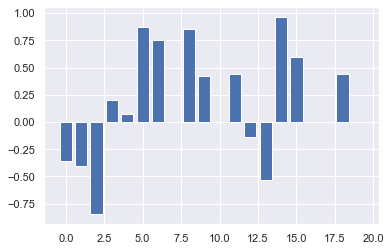

In [73]:
# Seems that inevitably, some of these sentences are going to get incorrect sentiment scores.
# I wonder what the mean compound score for the sentences will look like.

test_score_lst = []
for sent in df_sent_dom_topics['original_text'][:20]:
    test_score_lst.append(anakin.polarity_scores(sent)['compound'])

plt.bar(range(0,len(test_score_lst)),test_score_lst)

In [74]:
#How does this compare to the original full review?

full_test_sent = final_data['original_text'][0]
print(full_test_sent)
print(anakin.polarity_scores(full_test_sent))

Online review only...Simply put, it sucks ass...Glitches every other minute camps always bugged out. Bounty will bug out and not give exp or money. you. Infinite loading screens after you do missions or anything that requires loading  causing you to lose the exp and or cash you would have got from completion. Gold bars are over priced as hell and RS makes it a slow crappy process to get gold even without all the glitching.... With glitches its just a  never ending grind. Maybe the story is good but the online is frustrating to say the least.
{'neg': 0.119, 'neu': 0.863, 'pos': 0.018, 'compound': -0.8625}


In [75]:
# Compound score is overwhelmingly negative for the review as a whole.
# The review is both scathing and sarcastic, so I was not expecting a very clear negative.
# I believe the sentiment analyzer should be derive reasonably accurate sentiment scores, but it may not necessarily apply to short sentences.

#time to finish this analysis

#get compound sentiment score for all sentences
df_sent_dom_topics['compound_sentiment'] = df_sent_dom_topics['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])

In [76]:
df_sent_dom_topics.head(10)

,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment
0,Gaming Experience,0.7926,"[assglitche, minute, camp]","[simply, put, it, sucks, assglitches, every, o...",3,"story, graphic, rockstar, character, experienc...",simply put it sucks assglitches every other mi...,-0.3612
1,Online Mode,0.6523,"[infinite_loading_screens, mission, lose, cash...","[infinite, loading, screens, after, you, do, m...",5,"mission, player, server, bug, rockstar, money,...",infinite loading screens after you do missions...,-0.4019
2,Online Mode,0.7804,"[gold_bars, process, gold, glitching]","[gold, bars, are, over, priced, as, hell, and,...",4,"mission, player, server, bug, rockstar, money,...",gold bars are over priced as hell and rs makes...,-0.8481
3,Online Mode,0.8443,"[people, review, works_fine, pc, spec]","[people, claim, lot, in, reviews, that, they, ...",5,"mission, player, server, bug, rockstar, money,...",people claim lot in reviews that they cant run...,0.2023
4,Gaming Experience,0.6675,"[60_hours, story, ton, challenge]","[60, hours, through, am, just, over, 60, done,...",4,"story, graphic, rockstar, character, experienc...",60 hours through am just over 60 done the stor...,0.0772
5,Game Content & Design,0.7270,"[story, online]","[best, fucking, story, have, ever, played, onl...",2,"horse, way, people, mission, character, story,...",best fucking story have ever played onlines co...,0.8689
6,Bugs & Issues,0.7457,"[character, storyline]","[good, atmosphere, good, characters, and, soli...",2,"pc, crash, issue, problem, setting, steam, roc...",good atmosphere good characters and solid stor...,0.7506
7,Bugs & Issues,0.7208,"[world, character, surround]","[gets, you, immersed, in, the, world, the, cha...",3,"pc, crash, issue, problem, setting, steam, roc...",gets you immersed in the world the characters ...,0.0000
8,Bugs & Issues,0.4176,"[stuff, story]","[so, much, stuff, to, do, besides, story, and,...",2,"pc, crash, issue, problem, setting, steam, roc...",so much stuff to do besides story and quite en...,0.8576
9,Bugs & Issues,0.7295,"[world, future]","[hoping, for, another, game, in, this, world, ...",2,"pc, crash, issue, problem, setting, steam, roc...",hoping for another game in this world in the f...,0.4215


(array([ 219.,  657.,  720.,  900.,  642., 2658.,  695., 1408., 1401.,
        1521., 1007.]),
 array([-0.9961    , -0.81567273, -0.63524545, -0.45481818, -0.27439091,
        -0.09396364,  0.08646364,  0.26689091,  0.44731818,  0.62774545,
         0.80817273,  0.9886    ]),
 <a list of 11 Patch objects>)

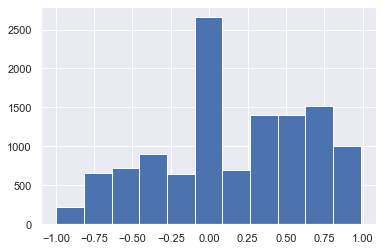

In [77]:
# Explore distribution of sentiment scores

sentiment_lst = df_sent_dom_topics['compound_sentiment']

plt.hist(sentiment_lst,bins=11) #give odd number so 0.00 has its own bin

In [78]:
# Most sentiment is positive, which is consistent with the rating on Steam

# Looking for a good cutoff point for sentiment, I started by setting the cutoffs to X > 0, X ==0, and X < 0 to reduce any chances of bias when setting the cutoffs

pos_lst = [x for x in sentiment_lst if x > 0] #find reasonable cutoffs for positive/negative
neutral_lst = [x for x in sentiment_lst if x == 0] #"neutral" compound scores
neg_lst = [x for x in sentiment_lst if x < 0] #cutoffs should not leave a large number of sentences to be classified as "neutral"

for i in [pos_lst, neutral_lst,neg_lst]:
    print(len(i)/len(sentiment_lst)) #Find out how many reviews would be classified under pos, neutral, or neg and what percentage of the total dataset are they?

0.53102806898884
0.18270206290158944
0.2862698681095705


In [79]:
# Seems like this will reduce Neutrals greatly, but it doesn't seem logical. Nobody really has a sentiment of 0.00000 on anything 
# That and P(X=0) on a continuous distribution is 0!

# From a logical standpoint, 0.1 sentiment in either direction should indicate a relatively clear leaning towards either positive or negative

pos_lst = [x for x in sentiment_lst if x > 0.1] #positive scores
neutral_lst = [x for x in sentiment_lst if x >=-0.1 and x <=0.1] #"neutral" compound scores
neg_lst = [x for x in sentiment_lst if x < -0.1] #cutoffs should not leave a large number of sentences to be classified as "neutral"

for i in [pos_lst, neutral_lst,neg_lst]:
    print(len(i)/len(sentiment_lst))

0.5091308758877241
0.22607372336827866
0.2647954007439973


In [80]:
pos_lst = [x for x in sentiment_lst if x > 0.2] #positive scores
neutral_lst = [x for x in sentiment_lst if x >=-0.2 and x <=0.2] #"neutral" compound scores
neg_lst = [x for x in sentiment_lst if x < -0.2] #cutoffs should not leave a large number of sentences to be classified as "neutral"

for i in [pos_lst, neutral_lst,neg_lst]:
    print(len(i)/len(sentiment_lst))

0.48241460940142034
0.2797598917822117
0.23782549881636794


In [81]:
# It seems that setting the cutoffs to 0.1 is a good option. Widening the boundary to 0.2 would result in a much higher Neutral count.

# Setting boundaries to 0.1 will slightly increase the number of reviews classified as neutral, but the tradeoff is worth it.

perc_dict = {}

for topic in list(topic_dict.values()):
    
    topic_mask = df_sent_dom_topics['dominant_topic']==topic
    topic_df = df_sent_dom_topics[topic_mask]
    
    sentiment_lst = topic_df['compound_sentiment']
    topic_pos = [x for x in sentiment_lst if x > 0.1]
    topic_neg = [x for x in sentiment_lst if x < -0.1]
    topic_neutral = [x for x in sentiment_lst if x not in topic_pos and x not in topic_neg]
    topic_total = len(sentiment_lst)
    
    topic_pos_perc = len(topic_pos)/topic_total
    topic_neutral_perc = len(topic_neutral)/topic_total
    topic_neg_perc = len(topic_neg)/topic_total
    
    perc_dict[topic]= [round(topic_pos_perc,3),round(topic_neutral_perc,3),round(topic_neg_perc,3)]
    #output percentages as positive, neutral, then negative

perc_dict

{'Gaming Experience': [0.468, 0.249, 0.283],
 'Bugs & Issues': [0.527, 0.217, 0.255],
 'Game Content & Design': [0.567, 0.204, 0.229],
 'Online Mode': [0.51, 0.213, 0.276]}

In [1]:
topic_total = len(sentiment_lst)

NameError: name 'sentiment_lst' is not defined

# Method 2
2. By review
    - Score sentiment on the whole review
    - Aggregate by topic then by sentiment type 
        - Positive, neutral, negative </br></br>

In [82]:
#Let's try this at the document level rather than sentence level, just to see what happens

final_data['compound_sentiment'] = final_data['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])

In [83]:
#sentiment analysis by review (NOT by sentence)

perc_dict2 = {}

for topic in list(topic_dict.values()):
    
    topic_mask = final_data['dominant_topic']==topic
    topic_df = final_data[topic_mask]
    
    sentiment_lst = topic_df['compound_sentiment']
    topic_pos = [x for x in sentiment_lst if x > 0.1]
    topic_neg = [x for x in sentiment_lst if x < -0.1]
    topic_neutral = [x for x in sentiment_lst if x not in topic_pos and x not in topic_neg]
    topic_total = len(sentiment_lst)
    
    topic_pos_perc = len(topic_pos)/topic_total
    topic_neutral_perc = len(topic_neutral)/topic_total
    topic_neg_perc = len(topic_neg)/topic_total
    
    perc_dict2[topic]= [round(topic_pos_perc,3),round(topic_neutral_perc,3),round(topic_neg_perc,3)]
    #output percentages as positive, neutral, then negative

perc_dict2

{'Gaming Experience': [0.808, 0.08, 0.111],
 'Bugs & Issues': [0.703, 0.058, 0.239],
 'Game Content & Design': [0.645, 0.117, 0.239],
 'Online Mode': [0.576, 0.069, 0.356]}

In [84]:
print("By sentence\n",perc_dict)
print("\nBy review\n",perc_dict2)

By sentence
 {'Gaming Experience': [0.468, 0.249, 0.283], 'Bugs & Issues': [0.527, 0.217, 0.255], 'Game Content & Design': [0.567, 0.204, 0.229], 'Online Mode': [0.51, 0.213, 0.276]}

By review
 {'Gaming Experience': [0.808, 0.08, 0.111], 'Bugs & Issues': [0.703, 0.058, 0.239], 'Game Content & Design': [0.645, 0.117, 0.239], 'Online Mode': [0.576, 0.069, 0.356]}


# Method 3

3. By sentence topics within each review
    - Break reviews into sentences (SpaCy)
    - Get dominant topic for each sentence
    - Score sentiment for each sentence
    - Group sentences and their sentiment scores by topic, for each review
    - Aggregate scores for all reviews by topic then by sentiment type </br></br>

### Preprocessing

In [46]:
final_data.head(2)

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords,compound_sentiment
0,Online Mode,"Online review only...Simply put, it sucks ass....",0.6938,"['review', 'ass', 'minute', 'camp', 'bug', 'mo...",18,"['hell', 'lose', 'completion', 'gold_bars', 'g...",18,"mission, player, server, bug, rockstar, money,...",-0.8625
1,Gaming Experience,It's a wonderful multiplayer and singleplayer ...,0.4671,"['connection_issues', 'friend']",2,"['friend', 'connection_issues']",2,"story, graphic, rockstar, character, experienc...",-0.3979


In [47]:
big_sent_lst2 =[] #For storing ALL sentences in the dataset. Another list will help label which reviews they came from

review_index_lst = [] #for storing all index numbers for each sentence so we can identify which reviews they belong to and thus group scores by topics and reviews

sent_df2 = pd.DataFrame() #For visualisation of sentence transformations and saving of data

review_count = 0
for review in final_data['original_text']:
    sent_tokens = parse_sent_tokenize(review)
    sent_tokens = remove_punc(sent_tokens)
    big_sent_lst2.extend(sent_tokens)
    
    review_count+=1
    review_num_lst = [str(review_count)] * len(sent_tokens) #for each review, create list of corresponding review index numbers that is as long as the number of sentences for easier groupby
    review_index_lst.extend(review_num_lst)

sent_df2['sentences'] = big_sent_lst2
sent_df2['review_number'] = review_index_lst
sent_df2.head()

,sentences,review_number
0,online review only,1
1,simply put it sucks assglitches every other mi...,1
2,bounty will bug out and not give exp or money,1
3,you,1
4,infinite loading screens after you do missions...,1


In [48]:
sent_df2['token_sentences'] = [x.split() for x in big_sent_lst2]

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]

sent_df2['sents_unstopped'] = sent_df2['token_sentences'].map(lambda x: remove_stopwords(x))
sent_df2['3gram_sentences'] = make_trigrams(sent_df2['sents_unstopped'])
sent_df2['3gram_sentences'] = sent_df2['3gram_sentences'].map(lambda x: spacy_lemma(x))

en_stopwords.extend(['one','two','three','thing','bit','total_war','time','10_10','love','fun','play','hour']) #after making bigrams, removing numbers should reduce noise

sent_df2['3gram_sentences_clean'] = sent_df2['3gram_sentences'].map(lambda x: remove_stopwords(x))
sent_df2['num_tokens'] = sent_df2['3gram_sentences_clean'].map(lambda x: len(x))

In [49]:
len(sent_df2)

22629

In [50]:
sent_df2.head(10)

,sentences,review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,online review only,1,"[online, review, only]","[online, review]","[, review]",[review],1
1,simply put it sucks assglitches every other mi...,1,"[simply, put, it, sucks, assglitches, every, o...","[simply, sucks, assglitches, minute, camps, bu...","[, , assglitche, minute, camp, ]","[assglitche, minute, camp]",3
2,bounty will bug out and not give exp or money,1,"[bounty, will, bug, out, and, not, give, exp, ...","[bounty, bug, exp, money]","[, , , money]",[money],1
3,you,1,[you],[],[],[],0
4,infinite loading screens after you do missions...,1,"[infinite, loading, screens, after, you, do, m...","[infinite, loading, screens, missions, require...","[infinite_loading_screens, mission, , , , lose...","[infinite_loading_screens, mission, lose, cash...",5
5,gold bars are over priced as hell and rs makes...,1,"[gold, bars, are, over, priced, as, hell, and,...","[gold, bars, priced, hell, rs, makes, slow, cr...","[gold_bars, , , , , , , process, gold, glitching]","[gold_bars, process, gold, glitching]",4
6,with glitches its just never ending grind,1,"[with, glitches, its, just, never, ending, grind]","[glitches, ending, grind]","[glitch, , ]",[glitch],1
7,maybe the story is good but the online is frus...,1,"[maybe, the, story, is, good, but, the, online...","[maybe, story, online, frustrating]","[, story, , ]",[story],1
8,it is wonderful multiplayer and singleplayer g...,2,"[it, is, wonderful, multiplayer, and, singlepl...","[wonderful, multiplayer, singleplayer, fix, aw...","[, , , , , connection_issues, ]",[connection_issues],1
9,mean you would not recommend headache to your ...,2,"[mean, you, would, not, recommend, headache, t...","[mean, recommend, headache, friend]","[, , , friend]",[friend],1


In [51]:
ultimate_sent_df = sent_df2[sent_df2['num_tokens']>1].reset_index(drop=True)

dropped_rows = abs(len(sent_df2)-len(ultimate_sent_df))/len(sent_df2)
print(dropped_rows)
print(len(ultimate_sent_df))

0.4773078792699633
11828


In [52]:
ultimate_sent_df.head(10)

,sentences,review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,simply put it sucks assglitches every other mi...,1,"[simply, put, it, sucks, assglitches, every, o...","[simply, sucks, assglitches, minute, camps, bu...","[, , assglitche, minute, camp, ]","[assglitche, minute, camp]",3
1,infinite loading screens after you do missions...,1,"[infinite, loading, screens, after, you, do, m...","[infinite, loading, screens, missions, require...","[infinite_loading_screens, mission, , , , lose...","[infinite_loading_screens, mission, lose, cash...",5
2,gold bars are over priced as hell and rs makes...,1,"[gold, bars, are, over, priced, as, hell, and,...","[gold, bars, priced, hell, rs, makes, slow, cr...","[gold_bars, , , , , , , process, gold, glitching]","[gold_bars, process, gold, glitching]",4
3,people claim lot in reviews that they cant run...,3,"[people, claim, lot, in, reviews, that, they, ...","[people, claim, reviews, run, works, fine, tim...","[people, , review, , works_fine, time, , pc, ,...","[people, review, works_fine, pc, spec]",5
4,60 hours through am just over 60 done the stor...,3,"[60, hours, through, am, just, over, 60, done,...","[60, hours, 60, story, tons, challenges, work]","[60_hours, , story, ton, challenge, ]","[60_hours, story, ton, challenge]",4
5,best fucking story have ever played onlines co...,4,"[best, fucking, story, have, ever, played, onl...","[best, fucking, story, played, onlines, cool, ...","[, , story, , online, , , , ]","[story, online]",2
6,good atmosphere good characters and solid stor...,6,"[good, atmosphere, good, characters, and, soli...","[atmosphere, characters, solid, storyline]","[, character, , storyline]","[character, storyline]",2
7,gets you immersed in the world the characters ...,6,"[gets, you, immersed, in, the, world, the, cha...","[gets, immersed, world, characters, gets, emot...","[, , world, character, , , , surround]","[world, character, surround]",3
8,so much stuff to do besides story and quite en...,6,"[so, much, stuff, to, do, besides, story, and,...","[stuff, story, engaging, pretty, fun]","[stuff, story, , , fun]","[stuff, story]",2
9,hoping for another game in this world in the f...,6,"[hoping, for, another, game, in, this, world, ...","[hoping, world, future]","[, world, future]","[world, future]",2


In [53]:
ultimate_sent_df.select_dtypes(include='O').describe()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


,sentences,review_number,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean
count,11828,11828,11828,11828,11828,11828
unique,11703,3549,11703,11687,11647,11301
top,you have been disconnected from red dead onlin...,3920,"[you, have, been, disconnected, from, red, dea...","[red, dead, pc]","[, story, gameplay]","[story, graphic]"
freq,4,74,4,5,6,24


In [ ]:
ultimate_sent_df.isnull().sum()

In [ ]:
ultimate_sent_df.describe()

In [89]:
# run model on newly-made sentence dataframe

documents2 = list(ultimate_sent_df['3gram_sentences_clean'])

dictionary2 = gensim.corpora.Dictionary(documents2)

dictionary2.filter_extremes(no_below = 5,no_above=0.5)  

corpus2 = [dictionary2.doc2bow(text) for text in documents2] #dictionary previously defined above

In [90]:
#credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this cell's code, which I modified to suit my needs

def format_topics_sentences(df,ldamodel=lda_model, corpus=corpus, documents=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each sentence
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topic_dict[str(topic_num)], round(prop_topic,4), topic_keywords]), ignore_index=True)   #replaced int(topic_num) with str so it can reference the topic dictionary
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    orig_contents = pd.DataFrame(df[['sentences','token_sentences']])
    docs = pd.Series(documents)
    sent_topics_df = pd.concat([sent_topics_df,docs, orig_contents], axis=1)
    return sent_topics_df

In [91]:
#generate dataframe
df_topic_sents_keywords = format_topics_sentences(ultimate_sent_df,ldamodel=lda_model, corpus=corpus2, documents=documents2)

In [92]:
# Format dataframe
df_sent_dom_topics = df_topic_sents_keywords.reset_index()

df_sent_dom_topics.columns = ['sent_no', 'dominant_topic', 'topic_perc_contrib', 'topic_keywords', 'tokens','original_text','token_sentence']

df_sent_dom_topics['num_tokens']=ultimate_sent_df['num_tokens']
df_sent_dom_topics['review_number']=ultimate_sent_df['review_number'].map(lambda x: int(x))

df_sent_dom_topics = df_sent_dom_topics[['review_number','dominant_topic','topic_perc_contrib','tokens','token_sentence','num_tokens','topic_keywords','original_text']]


# Show dataframe
df_sent_dom_topics.head(10)

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
0,1,Gaming Experience,0.7926,"[assglitche, minute, camp]","[simply, put, it, sucks, assglitches, every, o...",3,"story, graphic, rockstar, character, experienc...",simply put it sucks assglitches every other mi...
1,1,Online Mode,0.6523,"[infinite_loading_screens, mission, lose, cash...","[infinite, loading, screens, after, you, do, m...",5,"mission, player, server, bug, rockstar, money,...",infinite loading screens after you do missions...
2,1,Online Mode,0.7804,"[gold_bars, process, gold, glitching]","[gold, bars, are, over, priced, as, hell, and,...",4,"mission, player, server, bug, rockstar, money,...",gold bars are over priced as hell and rs makes...
3,3,Online Mode,0.8443,"[people, review, works_fine, pc, spec]","[people, claim, lot, in, reviews, that, they, ...",5,"mission, player, server, bug, rockstar, money,...",people claim lot in reviews that they cant run...
4,3,Gaming Experience,0.6675,"[60_hours, story, ton, challenge]","[60, hours, through, am, just, over, 60, done,...",4,"story, graphic, rockstar, character, experienc...",60 hours through am just over 60 done the stor...
5,4,Game Content & Design,0.7270,"[story, online]","[best, fucking, story, have, ever, played, onl...",2,"horse, way, people, mission, character, story,...",best fucking story have ever played onlines co...
6,6,Bugs & Issues,0.7457,"[character, storyline]","[good, atmosphere, good, characters, and, soli...",2,"pc, crash, issue, problem, setting, steam, roc...",good atmosphere good characters and solid stor...
7,6,Bugs & Issues,0.7209,"[world, character, surround]","[gets, you, immersed, in, the, world, the, cha...",3,"pc, crash, issue, problem, setting, steam, roc...",gets you immersed in the world the characters ...
8,6,Bugs & Issues,0.4176,"[stuff, story]","[so, much, stuff, to, do, besides, story, and,...",2,"pc, crash, issue, problem, setting, steam, roc...",so much stuff to do besides story and quite en...
9,6,Bugs & Issues,0.7295,"[world, future]","[hoping, for, another, game, in, this, world, ...",2,"pc, crash, issue, problem, setting, steam, roc...",hoping for another game in this world in the f...


In [93]:
max((df_sent_dom_topics['review_number'].unique())) #check that highest value of unique review numbers == len of review count

4836

In [94]:
df_sent_dom_topics['compound_sentiment'] = df_sent_dom_topics['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])
df_sent_dom_topics.head(10)

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment
0,1,Gaming Experience,0.7926,"[assglitche, minute, camp]","[simply, put, it, sucks, assglitches, every, o...",3,"story, graphic, rockstar, character, experienc...",simply put it sucks assglitches every other mi...,-0.3612
1,1,Online Mode,0.6523,"[infinite_loading_screens, mission, lose, cash...","[infinite, loading, screens, after, you, do, m...",5,"mission, player, server, bug, rockstar, money,...",infinite loading screens after you do missions...,-0.4019
2,1,Online Mode,0.7804,"[gold_bars, process, gold, glitching]","[gold, bars, are, over, priced, as, hell, and,...",4,"mission, player, server, bug, rockstar, money,...",gold bars are over priced as hell and rs makes...,-0.8481
3,3,Online Mode,0.8443,"[people, review, works_fine, pc, spec]","[people, claim, lot, in, reviews, that, they, ...",5,"mission, player, server, bug, rockstar, money,...",people claim lot in reviews that they cant run...,0.2023
4,3,Gaming Experience,0.6675,"[60_hours, story, ton, challenge]","[60, hours, through, am, just, over, 60, done,...",4,"story, graphic, rockstar, character, experienc...",60 hours through am just over 60 done the stor...,0.0772
5,4,Game Content & Design,0.7270,"[story, online]","[best, fucking, story, have, ever, played, onl...",2,"horse, way, people, mission, character, story,...",best fucking story have ever played onlines co...,0.8689
6,6,Bugs & Issues,0.7457,"[character, storyline]","[good, atmosphere, good, characters, and, soli...",2,"pc, crash, issue, problem, setting, steam, roc...",good atmosphere good characters and solid stor...,0.7506
7,6,Bugs & Issues,0.7209,"[world, character, surround]","[gets, you, immersed, in, the, world, the, cha...",3,"pc, crash, issue, problem, setting, steam, roc...",gets you immersed in the world the characters ...,0.0000
8,6,Bugs & Issues,0.4176,"[stuff, story]","[so, much, stuff, to, do, besides, story, and,...",2,"pc, crash, issue, problem, setting, steam, roc...",so much stuff to do besides story and quite en...,0.8576
9,6,Bugs & Issues,0.7295,"[world, future]","[hoping, for, another, game, in, this, world, ...",2,"pc, crash, issue, problem, setting, steam, roc...",hoping for another game in this world in the f...,0.4215


In [95]:
df_sent_dom_topics.to_csv('./dataframes/final_agg_sent_topics.csv')

In [96]:
#try a few ways of aggregating compound sentiment by topic for 1 review

toy_sent_data = df_sent_dom_topics[df_sent_dom_topics['review_number']==1]
toy_sent_data.head()

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment
0,1,Gaming Experience,0.7926,"[assglitche, minute, camp]","[simply, put, it, sucks, assglitches, every, o...",3,"story, graphic, rockstar, character, experienc...",simply put it sucks assglitches every other mi...,-0.3612
1,1,Online Mode,0.6523,"[infinite_loading_screens, mission, lose, cash...","[infinite, loading, screens, after, you, do, m...",5,"mission, player, server, bug, rockstar, money,...",infinite loading screens after you do missions...,-0.4019
2,1,Online Mode,0.7804,"[gold_bars, process, gold, glitching]","[gold, bars, are, over, priced, as, hell, and,...",4,"mission, player, server, bug, rockstar, money,...",gold bars are over priced as hell and rs makes...,-0.8481


In [97]:
toy_sent_data.groupby(['dominant_topic'])['compound_sentiment'].sum()

dominant_topic
Gaming Experience   -0.3612
Online Mode         -1.2500
Name: compound_sentiment, dtype: float64

In [98]:
toy_sent_data.groupby(['dominant_topic'])['compound_sentiment'].mean()

dominant_topic
Gaming Experience   -0.3612
Online Mode         -0.6250
Name: compound_sentiment, dtype: float64

In [99]:
toy_sent_data.groupby(['dominant_topic'])['compound_sentiment'].median()

dominant_topic
Gaming Experience   -0.3612
Online Mode         -0.6250
Name: compound_sentiment, dtype: float64

In [100]:
toy_sent_data.groupby(['dominant_topic'])['compound_sentiment'].count()

dominant_topic
Gaming Experience    1
Online Mode          2
Name: compound_sentiment, dtype: int64

# Deciding on Aggregation

The mean is the least preferred option because it includes outliers, which can skew the data.

Using sum is not much different from the mean, and in fact creates another problem because it doesn't work on the same scale as VADER (floating points from -1.0 to 1.0).

Median should work just fine. It should show a score that reflects the general direction of the sentiment, since it is the middle point in all of the data.

Text(0, 0.5, 'Number of sentences')

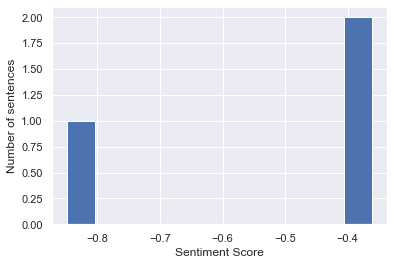

In [101]:
#Visualise distribution of sentiment scores
plt.hist(toy_sent_data['compound_sentiment'],bins=11) #use odd numbers so the neutral ones have their own bin in the centre
plt.xlabel('Sentiment Score')
plt.ylabel('Number of sentences')

In [102]:
print("mean:",toy_sent_data['compound_sentiment'].mean())
print("median:",toy_sent_data['compound_sentiment'].median())

mean: -0.5370666666666667
median: -0.4019


In [103]:
# The median is more reflective of the general sentiment of the review's sentences, but the score is not severely negative like the actual review.
# Maybe this problem has a simple solution.
# We convert everything to integers instead of floats

def sent_score_int(score_lst):
    int_scores = [(-1 if x <-0.1 else (0 if -0.1 <= x <= 0.1 else 1)) for x in score_lst]
    return int_scores

toy_sent_data['int_scores'] = sent_score_int(toy_sent_data['compound_sentiment'])
toy_sent_data.head()

C:\Users\Henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment,int_scores
0,1,Gaming Experience,0.7926,"[assglitche, minute, camp]","[simply, put, it, sucks, assglitches, every, o...",3,"story, graphic, rockstar, character, experienc...",simply put it sucks assglitches every other mi...,-0.3612,-1
1,1,Online Mode,0.6523,"[infinite_loading_screens, mission, lose, cash...","[infinite, loading, screens, after, you, do, m...",5,"mission, player, server, bug, rockstar, money,...",infinite loading screens after you do missions...,-0.4019,-1
2,1,Online Mode,0.7804,"[gold_bars, process, gold, glitching]","[gold, bars, are, over, priced, as, hell, and,...",4,"mission, player, server, bug, rockstar, money,...",gold bars are over priced as hell and rs makes...,-0.8481,-1


In [104]:
# Now, any score that is conclusively negative (x<-0.1) is assigned the value of -1; 0 for neutral (-0.1 < x < 0.1), 1 for positive (x > 0.1)
# The exact score is not important for this model. All we need is whether a review is positive, netural, or negative.

topic_df = toy_sent_data[toy_sent_data['dominant_topic'] == topic_dict['3']]

review_dict= {}

score_lst = list(topic_df['int_scores'])

rev_topic_pos = score_lst.count(1)/len(score_lst)
rev_topic_neutral = score_lst.count(0)/len(score_lst)
rev_topic_neg = score_lst.count(-1)/len(score_lst)

print("Positive:",rev_topic_pos)
print("Neutral:",rev_topic_neutral)
print("Negative:",rev_topic_neg)

review_scores = [rev_topic_pos, rev_topic_neutral, rev_topic_neg]

mx = max(review_scores)

#assign sentiment rating based on the dominant sentiment for the current topic
if mx == review_scores[0]:
    sentiment = 1

elif mx == review_scores[1]:
    sentiment = 0

else:
    sentiment = -1

review_dict[topic_dict['3']]=sentiment
print(review_dict)

Positive: 0.0
Neutral: 0.0
Negative: 1.0
{'Online Mode': -1}


In [106]:
t_dict = {'0':[],
          '1':[],
          '2':[],
          '3':[]
         }

t_dict['0'].append(1)
t_dict['0'].append(1)
t_dict['0'].append(-1)
t_dict

{'0': [1, 1, -1], '1': [], '2': [], '3': []}

In [107]:
score_dict = {topic_dict['0']:[],
              topic_dict['1']:[],
              topic_dict['2']:[],
              topic_dict['3']:[]
             }
score_dict

{'Gaming Experience': [],
 'Bugs & Issues': [],
 'Game Content & Design': [],
 'Online Mode': []}

In [108]:
#Transform sentiment scores for the larger dataset
df_sent_dom_topics['int_scores'] = sent_score_int(df_sent_dom_topics['compound_sentiment'])
df_sent_dom_topics.head()

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment,int_scores
0,1,Gaming Experience,0.7926,"[assglitche, minute, camp]","[simply, put, it, sucks, assglitches, every, o...",3,"story, graphic, rockstar, character, experienc...",simply put it sucks assglitches every other mi...,-0.3612,-1
1,1,Online Mode,0.6523,"[infinite_loading_screens, mission, lose, cash...","[infinite, loading, screens, after, you, do, m...",5,"mission, player, server, bug, rockstar, money,...",infinite loading screens after you do missions...,-0.4019,-1
2,1,Online Mode,0.7804,"[gold_bars, process, gold, glitching]","[gold, bars, are, over, priced, as, hell, and,...",4,"mission, player, server, bug, rockstar, money,...",gold bars are over priced as hell and rs makes...,-0.8481,-1
3,3,Online Mode,0.8443,"[people, review, works_fine, pc, spec]","[people, claim, lot, in, reviews, that, they, ...",5,"mission, player, server, bug, rockstar, money,...",people claim lot in reviews that they cant run...,0.2023,1
4,3,Gaming Experience,0.6675,"[60_hours, story, ton, challenge]","[60, hours, through, am, just, over, 60, done,...",4,"story, graphic, rockstar, character, experienc...",60 hours through am just over 60 done the stor...,0.0772,0


In [109]:
# Now we do the above for all topics in the whole review... which we will later transplant into a higher-level loop that goes through all reviews one by one in this manner

# define function to find mode

    # fixing a mistake I made earlier
    # the method I used above will return the 1st mode if there is more than 1 mode

def mode_function2(lst):
    counter = Counter(lst)
    _,val = counter.most_common(1)[0]
    return [x for x,y in counter.items() if y == val]

#init 5 lists in a dict to append scores to -- eliminate need to manipulate multiple review_dicts to aggregate scores
score_dict = {topic_dict['0']:[],
              topic_dict['1']:[],
              topic_dict['2']:[],
              topic_dict['3']:[]
             }

review_numbers = list(df_sent_dom_topics['review_number'].unique())[:2] #for now we will just take 2 reviews to test this loop

for i in review_numbers: 

    review_mask = df_sent_dom_topics['review_number'] == i
    review_df = df_sent_dom_topics[review_mask]

    for key in topic_dict:

        topic_df = review_df[review_df['dominant_topic'] == topic_dict[key]]  #get only relevant rows for the current topic

        if len(topic_df) == 0:
            pass

        else:

            score_lst = list(topic_df['int_scores'])
            mode_lst = mode_function2(score_lst)
            

            if len(mode_lst) ==1:     #ideally, we only have one mode in the list
                
                sentiment = mode_lst[0]

            elif len(mode_lst) >1:   #for dealing with multiple modes
                
                sentiment = 0 #since sentiment is mixed, assign neutral sentiment value

            score_dict[topic_dict[key]].append(sentiment) #finds corresponding list for corresponding topic to append the sentiment score to

print(score_dict)

{'Gaming Experience': [-1, 0], 'Bugs & Issues': [], 'Game Content & Design': [], 'Online Mode': [-1, 1]}


In [110]:
#verify results(1)
review_mask = df_sent_dom_topics['review_number'] == review_numbers[0]
review_df = df_sent_dom_topics[review_mask]
review_df.groupby('dominant_topic')['int_scores'].apply(lambda x: x.mode()) #used only here for quick verification -- 

dominant_topic      
Gaming Experience  0   -1
Online Mode        0   -1
Name: int_scores, dtype: int64

In [111]:
#verify results(2)
review_mask = df_sent_dom_topics['review_number'] == review_numbers[1]
review_df = df_sent_dom_topics[review_mask]
review_df.groupby('dominant_topic')['int_scores'].apply(lambda x: x.mode())

dominant_topic      
Gaming Experience  0    0
Online Mode        0    1
Name: int_scores, dtype: int64

In [112]:
#The test results match: 1 pos for Series Authenticity, 1 pos and 1 neutral for Characters, 1 pos for Strategic Gameplay, 2 neg for Tactical Gameplay, no results for Performance & Stability

#now running for all reviews

review_numbers = list(df_sent_dom_topics['review_number'].unique()) #iterates through ALL reviews in the dataset

def score_reviews(review_numbers,df):

    #init 5 lists in a dict to append scores to -- eliminate need to manipulate multiple review_dicts to aggregate scores
    score_dict = {topic_dict['0']:[],
                  topic_dict['1']:[],
                  topic_dict['2']:[],
                  topic_dict['3']:[]
                 }

    final_score_dict = {}
    
    for i in review_numbers: 

        review_mask = df['review_number'] == i
        review_df = df[review_mask]

        for key in topic_dict:

            topic_df = review_df[review_df['dominant_topic'] == topic_dict[key]]  #get only relevant rows for the current topic

            if len(topic_df) == 0:
                pass

            else:

                score_lst = list(topic_df['int_scores'])

                mode_lst = mode_function2(score_lst) 

                if len(mode_lst) ==1:     #ideally, we only have one mode in the list

                    sentiment = mode_lst[0]

                elif len(mode_lst) >1:   #for dealing with multiple modes

                    sentiment = 0 #Sentiment is mixed when there are multiple modes, thus assign neutral sentiment value


                score_dict[topic_dict[key]].append(sentiment) #finds corresponding list for corresponding topic to append the sentiment score to

    for key in score_dict:
        full_score_lst = score_dict[key]

        full_topic_pos = full_score_lst.count(1)/len(full_score_lst)
        full_topic_neutral = full_score_lst.count(0)/len(full_score_lst)
        full_topic_neg = full_score_lst.count(-1)/len(full_score_lst)

        full_scores = [round(full_topic_pos,3),round(full_topic_neutral,3),round(full_topic_neg,3)]

        final_score_dict[key] = full_scores

    return final_score_dict

In [113]:
test_topic_lst = []

test_review_num_lst = range(25)

test_int_scores = [-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,1,0,1,1,0,0,1,0,0,1,1,0,1,1]

for key in topic_dict.values():
    test_topic_lst_a = [key] * 5
    test_topic_lst.extend(test_topic_lst_a)

test_dict={'dominant_topic':test_topic_lst,
           'review_number':test_review_num_lst,
           'int_scores':test_int_scores
          }

uni_rn = list(sorted(set(test_review_num_lst)))

test_frame = pd.DataFrame(test_dict)
test_frame

ValueError: arrays must all be same length

In [114]:
score_reviews(uni_rn,test_frame)

NameError: name 'test_frame' is not defined

In [115]:
final_score_dict = score_reviews(review_numbers,df_sent_dom_topics)

In [116]:
# Summarise data in a dataframe for easier viewing

overall_score_df = pd.DataFrame(final_score_dict).T
#overall_score_df.index = ['Pos','Neutral','Neg']
overall_score_df.columns = ['Pos','Neutral','Neg']
overall_score_df

,Pos,Neutral,Neg
Gaming Experience,0.460,0.335,0.205
Bugs & Issues,0.521,0.285,0.194
Game Content & Design,0.541,0.280,0.179
Online Mode,0.489,0.288,0.223


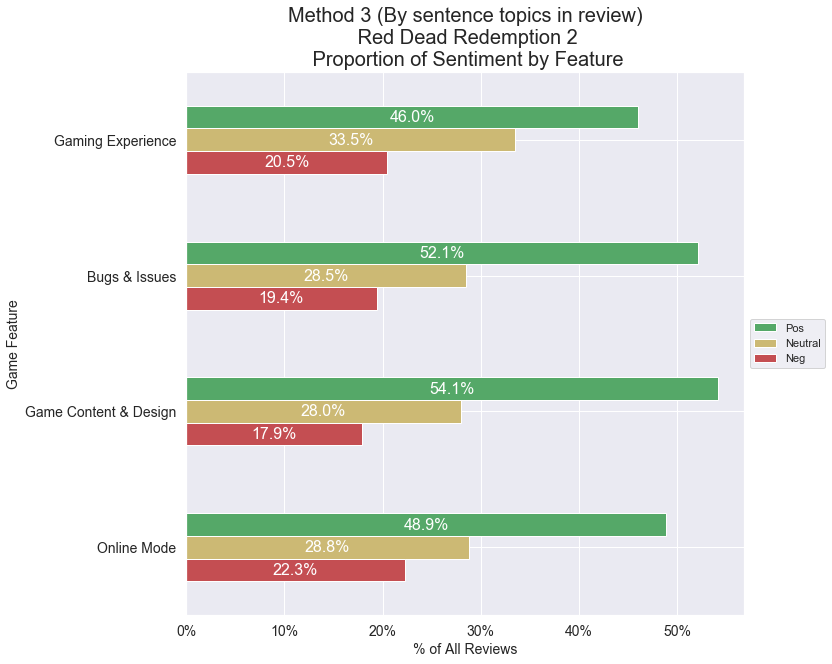

In [117]:
#plot visualisation for the results of the 3rd attempt at aggregation
ax = overall_score_df.plot(kind='barh',figsize=(10,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=14)
plt.ylabel('Game Feature',fontsize=14)
plt.title('Method 3 (By sentence topics in review)\n Red Dead Redemption 2\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

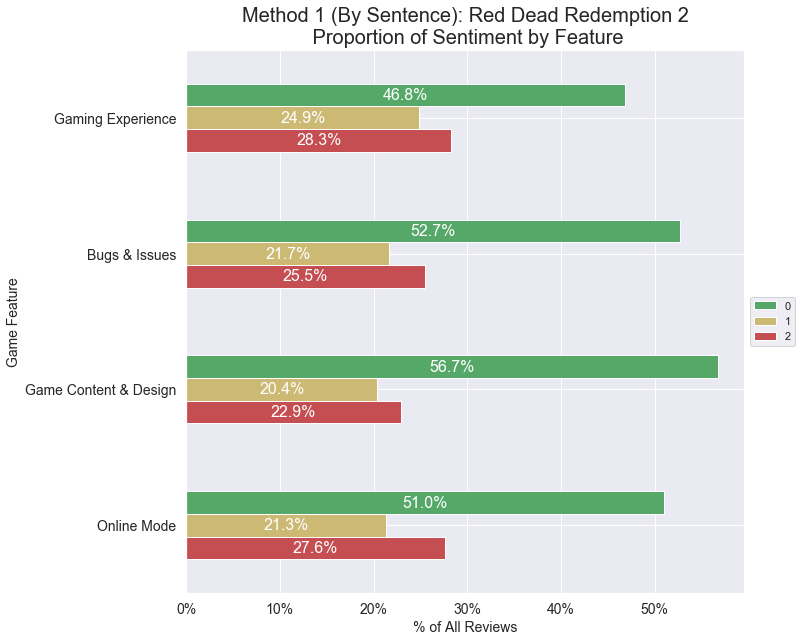

In [118]:
#comparison to Method 1 (by sentence)

ax = pd.DataFrame(perc_dict).T.plot(kind='barh',figsize=(10,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=14)
plt.ylabel('Game Feature',fontsize=14)
plt.title('Method 1 (By Sentence): Red Dead Redemption 2\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

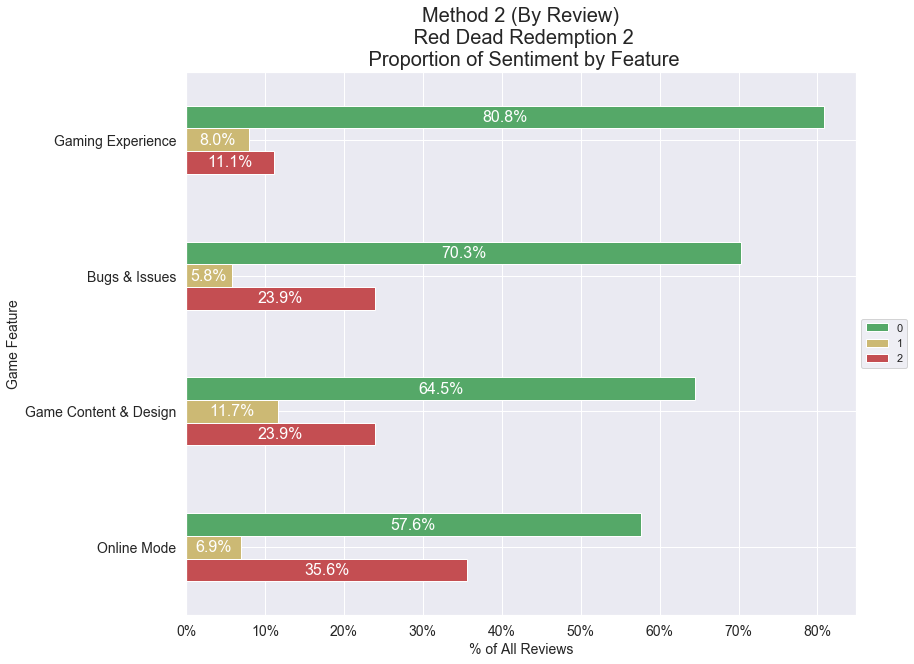

In [119]:
#comparison to other methods -- percentage_dict2, from the by-review approach 

ax = pd.DataFrame(perc_dict2).T.plot(kind='barh',figsize=(12,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=14)
plt.ylabel('Game Feature',fontsize=14)
plt.title('Method 2 (By Review)\n Red Dead Redemption 2\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

# Review of Method 3

#### Comparison to previous methods:
- Seems to output results very similar to Method 1.
- However, getting Method 1's results was more akin to random chance.

#### Method 3 differences:
- More rigorous.
- More closely follows the way a human would identify topics and score sentiments for each review.

#### Findings:
- Assigning neutral sentiment values to mixed reviews made the results to less in favour of Positive sentiment, more in favour of Neutral, and had little effect on Negative sentiment.
- This is a logical process; multiple dominating sentiments should logically indicate mixed sentiment

Method 3 has a more rigorous mathematical and logical process backing it, so I believe in it more than Methods 1 and 2.

But something is still missing... short sentences (as tokenised by SpaCy) are still a major issue. SpaCy tokenisation is less coherent (as tested above).

Perhaps we can go by paragraphs?

# Method 4: <span style = "color:blue">The Chosen One</span>

4. By "paragraphs" within each review   
    - Break reviews into "paragraphs" (Syntok; explained below)
    - Get dominant topic for each "paragraph"
    - Score sentiment for each "paragraph"
    - Get dominant topic for each "paragraph"
    - Group "paragraphs" and sentiment scores by topic, for each review 
    - Aggregate scores for all reviews by topic then by sentiment type

In [120]:
#Found a better sentence tokeniser
#SpaCy sentence tokeniser breaks sentences at intervals that tend to make sentences less coherent
#Syntok seems to tokenise coherent sentences
#https://github.com/fnl/syntok/blob/master/README.rst


#test syntok segmenter on one review
reviews = final_data['original_text'][:1]

dl = []

for i in range(len(reviews)):
    document = reviews[i]

    for paragraph in segmenter.process(document):
        pl = []
        sent_ct = 0
        for sentence in paragraph:
            sent_ct+=1
            sl = []
            for token in sentence:
                # roughly reproduce the input,
                # except for hyphenated word-breaks
                # and replacing "n't" contractions with "not",
                # separating tokens by single spaces
                sl.append(token.value)
            sl = [' '.join(w for w in sl)]

            print(str(sent_ct)+':',sl)  # print one sentence per line
        
            pl.append(sl)
        
        print("\n")  # separate paragraphs with newlines
        
        dl.append(pl)
        
    #print(dl)    #print this to see a list of lists of lists. Beware! Can look messy!

1: ['Online review only ...']
2: ['Simply put , it sucks ass ...']
3: ['Glitches every other minute camps always bugged out .']
4: ['Bounty will bug out and not give exp or money . you .']
5: ['Infinite loading screens after you do missions or anything that requires loading causing you to lose the exp and or cash you would have got from completion .']
6: ['Gold bars are over priced as hell and RS makes it a slow crappy process to get gold even without all the glitching ... .']
7: ['With glitches its just a never ending grind .']
8: ['Maybe the story is good but the online is frustrating to say the least .']




In [121]:
# SpaCy returned 41 sentences from the same review, whereas Syntok returned 27 coherent sentences. Seems promising.

# The following code includes clauses related to expandContractions which can be safely removed with no issue. 

# They are for demonstrating the paragraphing effect of expandContractions(), a complete accident!

def syntokenize(reviews,expcon=True, expconbreak=False):
    
    orig_sents = []

    review_tokens = []
    
    full_review_tokens = []
    
    review_index_lst = [] #for identifying review number

    for i in range(len(reviews)):
        document = reviews[i]
        orig_doc = document

        document = parse(document)
        
        if expcon==True:    #Assign False to see that Syntok tokenises differently without expandContractions()
            doc_prior = document
            
            document = expandContractions(document) #put this in an if-else to demonstrate that expandContractions is causing sentences to be made into paragraphs
            
            if expconbreak==True:
                #print("Original\n\n",orig_doc,"\n\n")
                print("Prior to expandContractions()\n\n",doc_prior,"\n\n")
                print("After expandContractions()\n\n",document)
                break
            
        else:
            pass

        document = [word for word in document.split() if len(word)>1 and len(word) <= len('pneumonoultramicroscopicsilicovolcanoconiosis')]
        document = ' '.join(word for word in document)

        for doc in segmenter.process(document):
            review_tokens = []
            
            for sentence in doc:
                sl = []
                
                for token in sentence:
                    
                    sl.append(token.value)
                
                sl = re.sub(r'\s([?.!"](?:\s|$))', r'\1', ' '.join(word for word in sl)) #remove whitespace only before punctuation at end of sentence

                review_tokens.append(sl)
                
            review_num_lst = [str(i)] * len(review_tokens) #for each review, create list of corresponding review index numbers that is as long as the number of sentences for easier groupby
            review_index_lst.extend(review_num_lst)
            
        full_review_tokens.extend(review_tokens) #join new sent as str to end of this list
        
    return full_review_tokens, review_index_lst

In [122]:
syntokenize(final_data['original_text'][:2])

(['online review only ... simply put , it sucks ass ... glitches every other minute camps always bugged out. bounty will bug out and not give exp or money. you. infinite loading screens after you do missions or anything that requires loading causing you to lose the exp and or cash you would have got from completion. gold bars are over priced as hell and rs makes it slow crappy process to get gold even without all the glitching .... with glitches its just never ending grind. maybe the story is good but the online is frustrating to say the least.',
  'it is wonderful multiplayer and singleplayer game , but until they fix all their awful connection issues have to just not recommend it. mean , you would not recommend headache to your friend.'],
 ['0', '1'])

In [123]:
# Happy accident! The text is being returned as paragraphs. I was looking for a tool that could do this, but couldn't find one.

# Originally it only returned single sentences as separated by '\n'. It also doesn't work well on Steam reviews. It works better on long documents.

# At this point I did some manual inspection. It turned out that expandContractions() is the one causing the sentences to become paragraphs.

# I have disabled expandContractions() to demonstrate the effect below.

syntokenize(final_data['original_text'][:1],expcon=False)

(['Online review only ...',
  'Simply put , it sucks ass ...',
  'Glitches every other minute camps always bugged out.',
  'Bounty will bug out and not give exp or money. you.',
  'Infinite loading screens after you do missions or anything that requires loading causing you to lose the exp and or cash you would have got from completion.',
  'Gold bars are over priced as hell and RS makes it slow crappy process to get gold even without all the glitching ....',
  'With glitches its just never ending grind.',
  'Maybe the story is good but the online is frustrating to say the least.'],
 ['0', '0', '0', '0', '0', '0', '0', '0'])

In [124]:
# Break out of the loop during expandContractions() just after the first run, just to see if there are significant formatting changes prior to other cleaning steps

# testing on more than 1 review
syntokenize(final_data['original_text'][:2],expcon=True,expconbreak=True)

Prior to expandContractions()

 Online review only...Simply put, it sucks ass...Glitches every other minute camps always bugged out. Bounty will bug out and not give exp or money. you. Infinite loading screens after you do missions or anything that requires loading  causing you to lose the exp and or cash you would have got from completion. Gold bars are over priced as hell and RS makes it a slow crappy process to get gold even without all the glitching.... With glitches its just a  never ending grind. Maybe the story is good but the online is frustrating to say the least. 


After expandContractions()

 online review only...simply put, it sucks ass...glitches every other minute camps always bugged out. bounty will bug out and not give exp or money. you. infinite loading screens after you do missions or anything that requires loading  causing you to lose the exp and or cash you would have got from completion. gold bars are over priced as hell and rs makes it a slow crappy process to ge

([], [])

In [125]:
#Further investigation may be warranted, but in any case it is a positive unintended effect. It does what I need it to do.
#It is also generally a better package for sentence tokenisation than SpaCy.

syntok_df = pd.DataFrame() #For visualisation of sentence transformations and saving of data

reviews = final_data['original_text'].reset_index(drop=True) #reset_index() needed because this returns a series with old index numbers

syntok_sent_lst, review_index_lst = syntokenize(reviews)

syntok_df['sentences'] = syntok_sent_lst
syntok_df['review_number'] = review_index_lst

print(len(syntok_df))
print(abs(len(syntok_df)-len(final_data)))
print(abs(len(syntok_df)-len(final_data))/len(final_data))
syntok_df.head()

5366
530
0.10959470636889991


,sentences,review_number
0,"online review only ... simply put , it sucks a...",0
1,it is wonderful multiplayer and singleplayer g...,1
2,people claim lot in reviews that they cant run...,2
3,60 hours through am just over 60 % done the st...,2
4,"best fucking story have ever played , online '...",3


In [126]:
# We gained 530 (~11%) more rows (as compared to original number of rows in of dataset) as new lines.

# Considering most reviews most reviews are very short (about 1 paragraph), this result is quite good.

# This would be less biased than going purely by the whole review. Each "paragraph" is tokenised as a very long sentence by Syntok.

# The sentences are more likely to be accurately classified!

syntok_df['clean_sentences'] = remove_punc(syntok_sent_lst)
syntok_df['token_sentences'] = [x.split() for x in syntok_df['clean_sentences']]

en_stopwords = list(set(STOPWORDS))
en_stopwords.extend(['good','better','great','lot','game','like','I','i'])
en_stopwords = [w for w in en_stopwords if w not in ['one','two','three']]

syntok_df['sents_unstopped'] = syntok_df['token_sentences'].map(lambda x: remove_stopwords(x))
syntok_df['3gram_sentences'] = make_trigrams(syntok_df['sents_unstopped'])

en_stopwords.extend(['one','two','three','thing','bit','total_war','time','10_10','love','fun','play','hour']) #after making bigrams, removing numbers should reduce noise

syntok_df['3gram_sentences_clean'] = syntok_df['3gram_sentences'].map(lambda x: spacy_lemma(x))

In [127]:
syntok_df['3gram_sentences_clean'] = syntok_df['3gram_sentences_clean'].map(lambda x: [y for y in x if y != ''])
syntok_df['num_tokens'] = syntok_df['3gram_sentences_clean'].map(lambda x: len(x))
syntok_df.head(5)

,sentences,review_number,clean_sentences,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,"online review only ... simply put , it sucks a...",0,online review only simply put it sucks ass ...,"[online, review, only, simply, put, it, sucks,...","[online, review, simply, sucks, ass, glitches,...","[online, review, simply, sucks, ass, glitches,...","[review, ass, minute, camp, bug, money, infini...",18
1,it is wonderful multiplayer and singleplayer g...,1,it is wonderful multiplayer and singleplayer g...,"[it, is, wonderful, multiplayer, and, singlepl...","[wonderful, multiplayer, singleplayer, fix, aw...","[wonderful, multiplayer, singleplayer, fix, aw...","[connection_issues, friend]",2
2,people claim lot in reviews that they cant run...,2,people claim lot in reviews that they cant run...,"[people, claim, lot, in, reviews, that, they, ...","[people, claim, reviews, run, works, fine, tim...","[people, claim, reviews, run, works_fine, time...","[people, review, works_fine, time, pc, spec, t...",10
3,60 hours through am just over 60 % done the st...,2,60 hours through am just over 60 done the sto...,"[60, hours, through, am, just, over, 60, done,...","[60, hours, 60, story, tons, challenges, work]","[60_hours, 60, story, tons, challenges, work]","[60_hours, story, ton, challenge]",4
4,"best fucking story have ever played , online '...",3,best fucking story have ever played online s ...,"[best, fucking, story, have, ever, played, onl...","[best, fucking, story, played, online, s, cool...","[best, fucking, story, played, online, s, cool...",[story],1


In [128]:
syntok_df['num_tokens'].describe()

count    5366.000000
mean       10.096720
std        18.220268
min         0.000000
25%         2.000000
50%         4.000000
75%        11.000000
max       268.000000
Name: num_tokens, dtype: float64

In [129]:
final_syntok_df = syntok_df[syntok_df['num_tokens']>1].reset_index(drop=True)  #drop any syntok sentences that have less than 2 tokens

dropped_rows = abs(len(final_syntok_df)-len(syntok_df))/len(syntok_df)
print(dropped_rows)
print(len(final_syntok_df))

0.2171077152441297
4201


In [130]:
final_syntok_df.head(10)

,sentences,review_number,clean_sentences,token_sentences,sents_unstopped,3gram_sentences,3gram_sentences_clean,num_tokens
0,"online review only ... simply put , it sucks a...",0,online review only simply put it sucks ass ...,"[online, review, only, simply, put, it, sucks,...","[online, review, simply, sucks, ass, glitches,...","[online, review, simply, sucks, ass, glitches,...","[review, ass, minute, camp, bug, money, infini...",18
1,it is wonderful multiplayer and singleplayer g...,1,it is wonderful multiplayer and singleplayer g...,"[it, is, wonderful, multiplayer, and, singlepl...","[wonderful, multiplayer, singleplayer, fix, aw...","[wonderful, multiplayer, singleplayer, fix, aw...","[connection_issues, friend]",2
2,people claim lot in reviews that they cant run...,2,people claim lot in reviews that they cant run...,"[people, claim, lot, in, reviews, that, they, ...","[people, claim, reviews, run, works, fine, tim...","[people, claim, reviews, run, works_fine, time...","[people, review, works_fine, time, pc, spec, t...",10
3,60 hours through am just over 60 % done the st...,2,60 hours through am just over 60 done the sto...,"[60, hours, through, am, just, over, 60, done,...","[60, hours, 60, story, tons, challenges, work]","[60_hours, 60, story, tons, challenges, work]","[60_hours, story, ton, challenge]",4
4,fantastic experience. did not play online. goo...,5,fantastic experience did not play online good ...,"[fantastic, experience, did, not, play, online...","[fantastic, experience, play, online, atmosphe...","[fantastic, experience, play, online, atmosphe...","[experience, atmosphere, character, storyline,...",15
5,rockstar games did good job at rushing with th...,6,rockstar games did good job at rushing with th...,"[rockstar, games, did, good, job, at, rushing,...","[rockstar, games, job, rushing, pc, version, t...","[rockstar_games, job, rushing, pc_version, ter...","[rockstar_games, pc_version, constant_crashing...",9
6,"the perfect game. it has everything it needs ,...",7,the perfect game it has everything it needs g...,"[the, perfect, game, it, has, everything, it, ...","[perfect, needs, story, amazing, gameplay, voi...","[perfect, needs, story, amazing, gameplay, voi...","[story, gameplay, voice_acting, character, ope...",8
7,"single player is blast. dunno about online , s...",8,single player is blast dunno about online sus...,"[single, player, is, blast, dunno, about, onli...","[single, player, blast, dunno, online, suspect...","[single_player, blast, dunno, online, suspect,...","[single_player, blast, ass]",3
8,have played 55 hours and 41 of the story now. ...,11,have played 55 hours and 41 of the story now f...,"[have, played, 55, hours, and, 41, of, the, st...","[played, 55, hours, 41, story, followed, main,...","[played, 55, hours, 41, story, followed, main_...","[hour, story, main_missions, mission, road, wo...",52
9,now this review is more based on my own comput...,12,now this review is more based on my own comput...,"[now, this, review, is, more, based, on, my, o...","[review, based, computers, performance, warned...","[review_based, computers, performance, warned,...","[review_based, computer, performance, graphics...",17


In [131]:
documents3 = list(final_syntok_df['3gram_sentences_clean'])  

dictionary3 = gensim.corpora.Dictionary(documents3)

dictionary3.filter_extremes(no_below = 5,no_above=0.5)     

corpus3 = [dictionary3.doc2bow(text) for text in documents3]

In [132]:
#generate dataframe
df_topic_syntok_keywords = format_topics_sentences(final_syntok_df,ldamodel=lda_model, corpus=corpus3, documents=documents3)

In [133]:
# Format dataframe
syntok_dom_topics = df_topic_syntok_keywords.reset_index()

syntok_dom_topics.columns = ['sent_no', 'dominant_topic', 'topic_perc_contrib', 'topic_keywords', 'tokens','original_text','token_sentence']

syntok_dom_topics['num_tokens']=final_syntok_df['num_tokens']
syntok_dom_topics['review_number']=final_syntok_df['review_number'].map(lambda x: int(x))

syntok_dom_topics = syntok_dom_topics[['review_number','dominant_topic','topic_perc_contrib','tokens','token_sentence','num_tokens','topic_keywords','original_text']]


# Show dataframe
syntok_dom_topics.head(10)

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text
0,0,Online Mode,0.6938,"[review, ass, minute, camp, bug, money, infini...","[online, review, only, simply, put, it, sucks,...",18,"mission, player, server, bug, rockstar, money,...","online review only ... simply put , it sucks a..."
1,1,Gaming Experience,0.4671,"[connection_issues, friend]","[it, is, wonderful, multiplayer, and, singlepl...",2,"story, graphic, rockstar, character, experienc...",it is wonderful multiplayer and singleplayer g...
2,2,Bugs & Issues,0.5936,"[people, review, works_fine, time, pc, spec, t...","[people, claim, lot, in, reviews, that, they, ...",10,"pc, crash, issue, problem, setting, steam, roc...",people claim lot in reviews that they cant run...
3,2,Gaming Experience,0.6778,"[60_hours, story, ton, challenge]","[60, hours, through, am, just, over, 60, done,...",4,"story, graphic, rockstar, character, experienc...",60 hours through am just over 60 % done the st...
4,5,Gaming Experience,0.8278,"[experience, atmosphere, character, storyline,...","[fantastic, experience, did, not, play, online...",15,"story, graphic, rockstar, character, experienc...",fantastic experience. did not play online. goo...
5,6,Bugs & Issues,0.7994,"[rockstar_games, pc_version, constant_crashing...","[rockstar, games, did, good, job, at, rushing,...",9,"pc, crash, issue, problem, setting, steam, roc...",rockstar games did good job at rushing with th...
6,7,Gaming Experience,0.8290,"[story, gameplay, voice_acting, character, ope...","[the, perfect, game, it, has, everything, it, ...",8,"story, graphic, rockstar, character, experienc...","the perfect game. it has everything it needs ,..."
7,8,Gaming Experience,0.8463,"[single_player, blast, ass]","[single, player, is, blast, dunno, about, onli...",3,"story, graphic, rockstar, character, experienc...","single player is blast. dunno about online , s..."
8,11,Game Content & Design,0.6546,"[hour, story, main_missions, mission, road, wo...","[have, played, 55, hours, and, 41, of, the, st...",52,"horse, way, people, mission, character, story,...",have played 55 hours and 41 of the story now. ...
9,12,Game Content & Design,0.6284,"[review_based, computer, performance, graphics...","[now, this, review, is, more, based, on, my, o...",17,"horse, way, people, mission, character, story,...",now this review is more based on my own comput...


In [134]:
max((syntok_dom_topics['review_number'].unique())) #check that highest value of unique review numbers == len of review count

4835

In [135]:
syntok_dom_topics['compound_sentiment'] = syntok_dom_topics['original_text'].map(lambda x: anakin.polarity_scores(x)['compound'])
syntok_dom_topics['int_scores']=sent_score_int(syntok_dom_topics['compound_sentiment'])
syntok_dom_topics.head(10)

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment,int_scores
0,0,Online Mode,0.6938,"[review, ass, minute, camp, bug, money, infini...","[online, review, only, simply, put, it, sucks,...",18,"mission, player, server, bug, rockstar, money,...","online review only ... simply put , it sucks a...",-0.8968,-1
1,1,Gaming Experience,0.4671,"[connection_issues, friend]","[it, is, wonderful, multiplayer, and, singlepl...",2,"story, graphic, rockstar, character, experienc...",it is wonderful multiplayer and singleplayer g...,-0.3979,-1
2,2,Bugs & Issues,0.5936,"[people, review, works_fine, time, pc, spec, t...","[people, claim, lot, in, reviews, that, they, ...",10,"pc, crash, issue, problem, setting, steam, roc...",people claim lot in reviews that they cant run...,0.7239,1
3,2,Gaming Experience,0.6778,"[60_hours, story, ton, challenge]","[60, hours, through, am, just, over, 60, done,...",4,"story, graphic, rockstar, character, experienc...",60 hours through am just over 60 % done the st...,0.0772,0
4,5,Gaming Experience,0.8278,"[experience, atmosphere, character, storyline,...","[fantastic, experience, did, not, play, online...",15,"story, graphic, rockstar, character, experienc...",fantastic experience. did not play online. goo...,0.9772,1
5,6,Bugs & Issues,0.7994,"[rockstar_games, pc_version, constant_crashing...","[rockstar, games, did, good, job, at, rushing,...",9,"pc, crash, issue, problem, setting, steam, roc...",rockstar games did good job at rushing with th...,-0.8959,-1
6,7,Gaming Experience,0.8290,"[story, gameplay, voice_acting, character, ope...","[the, perfect, game, it, has, everything, it, ...",8,"story, graphic, rockstar, character, experienc...","the perfect game. it has everything it needs ,...",0.9819,1
7,8,Gaming Experience,0.8463,"[single_player, blast, ass]","[single, player, is, blast, dunno, about, onli...",3,"story, graphic, rockstar, character, experienc...","single player is blast. dunno about online , s...",-0.2960,-1
8,11,Game Content & Design,0.6546,"[hour, story, main_missions, mission, road, wo...","[have, played, 55, hours, and, 41, of, the, st...",52,"horse, way, people, mission, character, story,...",have played 55 hours and 41 of the story now. ...,-0.8856,-1
9,12,Game Content & Design,0.6284,"[review_based, computer, performance, graphics...","[now, this, review, is, more, based, on, my, o...",17,"horse, way, people, mission, character, story,...",now this review is more based on my own comput...,-0.9028,-1


(array([ 266.,  205.,  174.,  172.,  298.,  156.,  250.,  346.,  689.,
        1645.]),
 array([-9.9910e-01, -7.9923e-01, -5.9936e-01, -3.9949e-01, -1.9962e-01,
         2.5000e-04,  2.0012e-01,  3.9999e-01,  5.9986e-01,  7.9973e-01,
         9.9960e-01]),
 <a list of 10 Patch objects>)

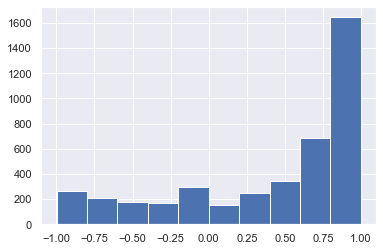

In [136]:
plt.hist(syntok_dom_topics['compound_sentiment'])

(array([ 893.,    0.,    0.,    0.,    0.,  287.,    0.,    0.,    0.,
        3021.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

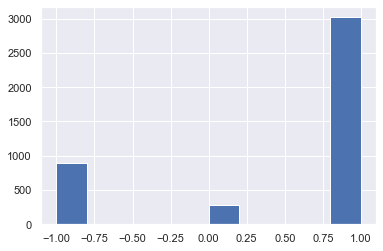

In [137]:
plt.hist(syntok_dom_topics['int_scores'])

In [138]:
syntok_plot_df_1 = syntok_dom_topics[syntok_dom_topics['num_tokens']>=5]
syntok_plot_df_2 = syntok_dom_topics[syntok_dom_topics['num_tokens']>=2]

In [139]:
review_numbers_5tokens = list(syntok_plot_df_1['review_number'].unique())
review_numbers_2tokens = list(syntok_plot_df_2['review_number'].unique())

final_score_dict_5tokens = score_reviews(review_numbers_5tokens,syntok_plot_df_1)
final_score_dict_2tokens = score_reviews(review_numbers_2tokens,syntok_plot_df_2)

In [140]:
print(final_score_dict_5tokens,'\n')
print(final_score_dict_2tokens,'\n')

{'Gaming Experience': [0.778, 0.031, 0.191], 'Bugs & Issues': [0.676, 0.049, 0.275], 'Game Content & Design': [0.702, 0.043, 0.255], 'Online Mode': [0.581, 0.075, 0.344]} 

{'Gaming Experience': [0.777, 0.062, 0.161], 'Bugs & Issues': [0.677, 0.084, 0.239], 'Game Content & Design': [0.684, 0.07, 0.246], 'Online Mode': [0.582, 0.121, 0.297]} 



In [141]:
syntok_score_df_1 = pd.DataFrame(final_score_dict_5tokens).T
#overall_score_df_1.index = ['Pos','Neutral','Neg']
syntok_score_df_1.columns = ['Pos','Neutral','Neg']
syntok_score_df_1

,Pos,Neutral,Neg
Gaming Experience,0.778,0.031,0.191
Bugs & Issues,0.676,0.049,0.275
Game Content & Design,0.702,0.043,0.255
Online Mode,0.581,0.075,0.344


In [142]:
syntok_score_df_2 = pd.DataFrame(final_score_dict_2tokens).T
#overall_score_df_2.index = ['Pos','Neutral','Neg']
syntok_score_df_2.columns = ['Pos','Neutral','Neg']
syntok_score_df_2

,Pos,Neutral,Neg
Gaming Experience,0.777,0.062,0.161
Bugs & Issues,0.677,0.084,0.239
Game Content & Design,0.684,0.070,0.246
Online Mode,0.582,0.121,0.297


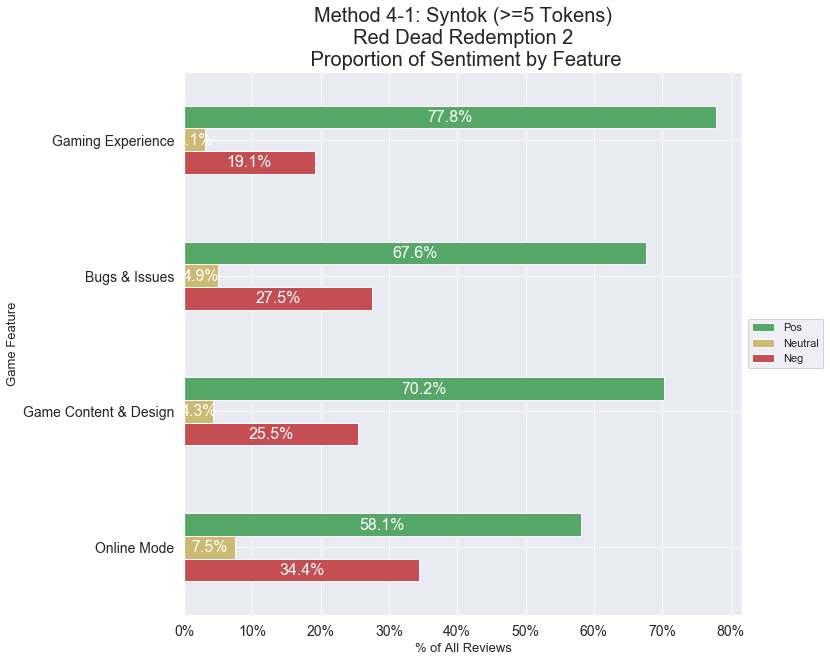

In [143]:
#plot visualisation, 4th attempt at aggregation

#WARNING: 5 tokens is the MEDIAN number of tokens! This visualisation is for only HALF of the usable data!

ax = syntok_score_df_1.plot(kind='barh',figsize=(10,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Method 4-1: Syntok (>=5 Tokens)\nRed Dead Redemption 2\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

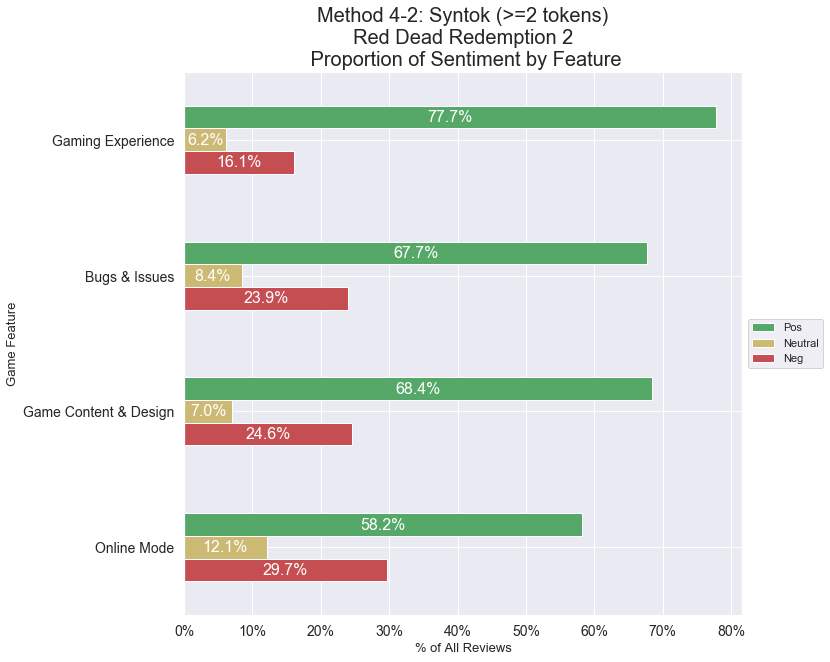

In [144]:
#plot visualisation, 4th attempt at aggregation
#75% of the data is intact (2 tokens is 25th Percentile)

ax = syntok_score_df_2.plot(kind='barh',figsize=(10,10),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Method 4-2: Syntok (>=2 tokens)\nRed Dead Redemption 2\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

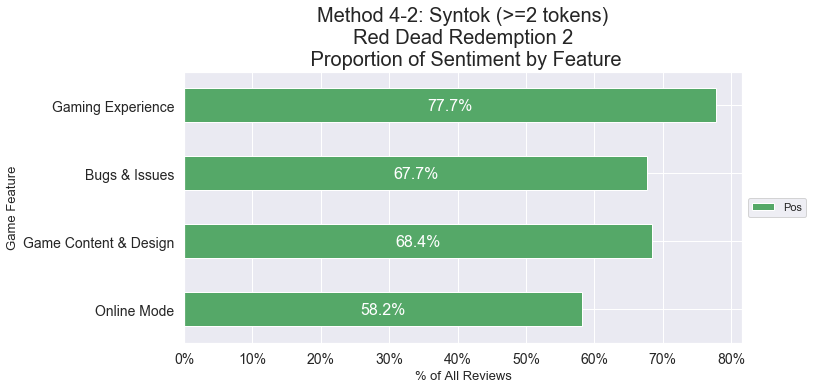

In [145]:
ax = syntok_score_df_2['Pos'].plot(kind='barh',figsize=(10,5),sort_columns=True,color=['g'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Method 4-2: Syntok (>=2 tokens)\nRed Dead Redemption 2\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

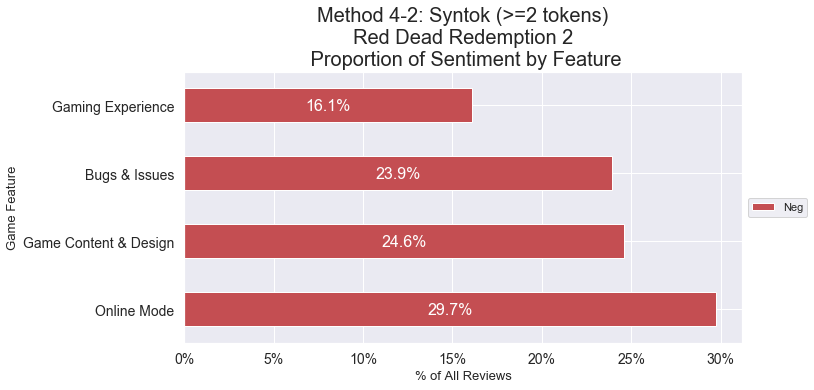

In [146]:
ax = syntok_score_df_2['Neg'].plot(kind='barh',figsize=(10,5),sort_columns=True,color=['r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Method 4-2: Syntok (>=2 tokens)\nRed Dead Redemption 2\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

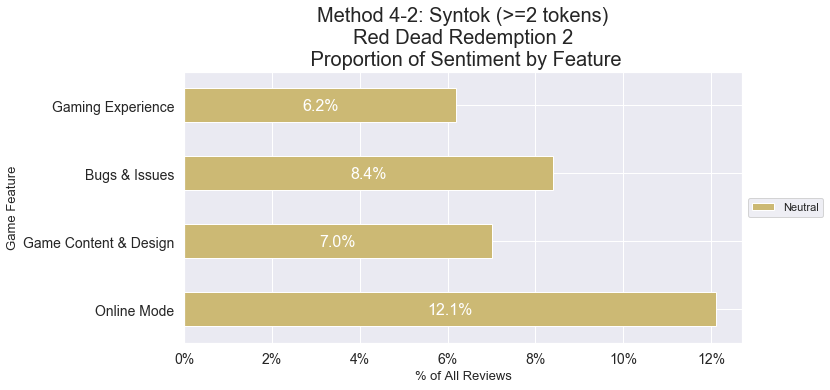

In [147]:
ax = syntok_score_df_2['Neutral'].plot(kind='barh',figsize=(10,5),sort_columns=True,color=['y'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Method 4-2: Syntok (>=2 tokens)\nRed Dead Redemption 2\n Proportion of Sentiment by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=16,color='w')

# Review: Method 4

Results with Syntok tokenisation look similar to Method 2 (by Review), but the results more reliable.

Method 4 results are much less likely to be due to random chance, due to the methodology.

I find this method to be a nice sweet spot that balances between bias and variance. 

Method ignores the context of sentences in their respective reviews and has flawed tokenisation.

Method 2 scores review sentiment on all the text but assigns the score to onl 1 topic out of several . 

Methods 1 and 3 both present risk of high misclassification rates because they go by extremely short sentences.

Method 4 results also more cleaerly indicate areas that need improvement while keeping neutral scores low.

I will go with the Method 4 (using 2 or more tokens).

In [148]:
mask = (syntok_dom_topics['topic_perc_contrib'] >0.7) & (syntok_dom_topics['compound_sentiment'] >0.7) & (syntok_dom_topics['num_tokens']>5)
most_pos_df = syntok_dom_topics[mask].reset_index(drop=True)[['review_number','dominant_topic','original_text','compound_sentiment']]
most_pos_df.head()

,review_number,dominant_topic,original_text,compound_sentiment
0,5,Gaming Experience,fantastic experience. did not play online. goo...,0.9772
1,7,Gaming Experience,"the perfect game. it has everything it needs ,...",0.9819
2,13,Gaming Experience,( I am sure the next game will be prequel abou...,0.8885
3,34,Gaming Experience,when you take the amazing world design and cre...,0.9830
4,57,Gaming Experience,this is for sure the best rockstar game have e...,0.8655


In [149]:
mask = (syntok_dom_topics['topic_perc_contrib'] >0.7) & (syntok_dom_topics['compound_sentiment'] <-0.5) & (syntok_dom_topics['num_tokens']>5)
most_neg_df = syntok_dom_topics[mask].reset_index(drop=True)[['review_number','dominant_topic','original_text','compound_sentiment']]
most_neg_df.head()

,review_number,dominant_topic,original_text,compound_sentiment
0,6,Bugs & Issues,rockstar games did good job at rushing with th...,-0.8959
1,72,Game Content & Design,its pve game where pvp player get to harass yo...,-0.8271
2,335,Gaming Experience,- bad guys try to rob you and you kill them an...,-0.8910
3,446,Game Content & Design,no doubt this is one of the greatest game of m...,-0.8292
4,471,Game Content & Design,do not understand the hype/appeal of this game...,-0.7331


Text(0.5, 1.0, 'Class Balance of Documents')

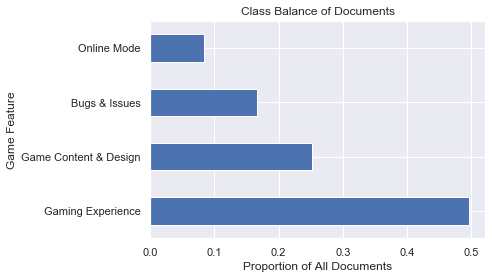

In [150]:
# Currently, sentiment scores do not account for class balance, so the data is noisy
# weight the scores by the class balance?
syntok_dom_topics['dominant_topic'].value_counts(normalize=True).plot(kind='barh')
plt.xlabel('Proportion of All Documents')
plt.ylabel('Game Feature')
plt.title('Class Balance of Documents')

In [151]:
cls_weights = dict(syntok_dom_topics['dominant_topic'].value_counts(normalize=True))
cls_weights

{'Gaming Experience': 0.49678647940966436,
 'Game Content & Design': 0.25255891454415613,
 'Bugs & Issues': 0.16662699357295882,
 'Online Mode': 0.08402761247322066}

In [152]:
for key, value in cls_weights.items():
    cls_weights[key] = 1-value    #give more weight to items that appear less in the class

cls_weights

{'Gaming Experience': 0.5032135205903356,
 'Game Content & Design': 0.7474410854558439,
 'Bugs & Issues': 0.8333730064270412,
 'Online Mode': 0.9159723875267793}

In [153]:
wtd_score_lst = []

for i in range(len(syntok_dom_topics)):
    wtd_score = cls_weights[syntok_dom_topics['dominant_topic'][i]] * syntok_dom_topics['compound_sentiment'][i]
    
    wtd_score_lst.append(wtd_score)


syntok_dom_topics['weighted_compound_sentiment'] = wtd_score_lst
syntok_dom_topics.head()

,review_number,dominant_topic,topic_perc_contrib,tokens,token_sentence,num_tokens,topic_keywords,original_text,compound_sentiment,int_scores,weighted_compound_sentiment
0,0,Online Mode,0.6938,"[review, ass, minute, camp, bug, money, infini...","[online, review, only, simply, put, it, sucks,...",18,"mission, player, server, bug, rockstar, money,...","online review only ... simply put , it sucks a...",-0.8968,-1,-0.821444
1,1,Gaming Experience,0.4671,"[connection_issues, friend]","[it, is, wonderful, multiplayer, and, singlepl...",2,"story, graphic, rockstar, character, experienc...",it is wonderful multiplayer and singleplayer g...,-0.3979,-1,-0.200229
2,2,Bugs & Issues,0.5936,"[people, review, works_fine, time, pc, spec, t...","[people, claim, lot, in, reviews, that, they, ...",10,"pc, crash, issue, problem, setting, steam, roc...",people claim lot in reviews that they cant run...,0.7239,1,0.603279
3,2,Gaming Experience,0.6778,"[60_hours, story, ton, challenge]","[60, hours, through, am, just, over, 60, done,...",4,"story, graphic, rockstar, character, experienc...",60 hours through am just over 60 % done the st...,0.0772,0,0.038848
4,5,Gaming Experience,0.8278,"[experience, atmosphere, character, storyline,...","[fantastic, experience, did, not, play, online...",15,"story, graphic, rockstar, character, experienc...",fantastic experience. did not play online. goo...,0.9772,1,0.491740


In [154]:
#get most positive or negative sentences by dominant topic

def get_top_sents(contrib, compound, tokens,desired):

    top_sent_dict = {}
    
    for topic in topic_dict.values():

        
        topic_df = syntok_dom_topics[syntok_dom_topics['dominant_topic']==topic]
        
        if compound >0.1:
        
            sent_mask = (syntok_dom_topics['topic_perc_contrib'] >= contrib) & (syntok_dom_topics['compound_sentiment'] > compound) & (syntok_dom_topics['num_tokens'] >= tokens)

            top_sents = topic_df[sent_mask][['review_number','dominant_topic','original_text','tokens','compound_sentiment','weighted_compound_sentiment']]
            
            top_sents = top_sents.sort_values(['compound_sentiment'],ascending = False)
            
            top_x_sents = list(top_sents['original_text'])[:desired]
            
            top_sent_dict[topic] = top_x_sents
            
        elif compound <-0.1:
            
            sent_mask = (syntok_dom_topics['topic_perc_contrib'] >= contrib) & (syntok_dom_topics['compound_sentiment'] < compound) & (syntok_dom_topics['num_tokens'] >= tokens)
            
            top_sents = topic_df[sent_mask][['review_number','dominant_topic','original_text','tokens','compound_sentiment','weighted_compound_sentiment']]
            
            top_sents = top_sents.sort_values(['compound_sentiment'],ascending = True)
            
            top_x_sents = list(top_sents['original_text'])[:desired]
            
            top_sent_dict[topic] = top_x_sents
            
        else:
            
            sent_mask = (syntok_dom_topics['topic_perc_contrib'] >= contrib) & (-0.1 <= syntok_dom_topics['compound_sentiment'] <= 0.1) & (syntok_dom_topics['num_tokens'] >= tokens)
            
            top_sents = topic_df[sent_mask][['review_number','dominant_topic','original_text','tokens','compound_sentiment','weighted_compound_sentiment']]
            
            top_sents = top_sents.sort_values(['compound_sentiment'],ascending = False)
            
            top_x_sents = list(top_sents['original_text'])[:desired] #neural sentiments
        
            top_sent_dict[topic] = top_x_sents
            
    
    return top_sent_dict

In [155]:
# Get 2 top reviews from each category (change the last integer to vary this)

top_pos_dict = get_top_sents(0.7,0.7,5,2)
for topic in topic_dict.values():
    print('***',topic,'***\n')
    for i in range(len(top_pos_dict[topic])):
        print('('+str(i+1)+')',top_pos_dict[topic][i],'\n')

*** Gaming Experience ***

(1) amazing realistic open world story based action adventure game with loveable characters and one of the greatest stories have ever experienced. cons : - some technical problems/glitches , and lots of crashes - too much handholding in most story missions - some weird restrictions to your freedom in the open world - inconsistency with some gameplay mechanics - spoilers : [ spoiler ] too much money after the ending , so there was not any reason to continue playing after beating the game [ / spoiler ] pros : - amazingly well written story , one of the best have ever played through - like able/hate able characters with deep personalities - beautiful open world - lots of attention to detail - great music - realism - best voice acting in any game have played definitely getting in my top favourite games ( kcd , tw3 , fnv , rdr2 ). am only reviewing the story mode here , btw. 

(2) incredible game! it has everything one would want from game. the visuals are stunnin

C:\Users\Henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [156]:
#get 2 top negative reviews from each category

top_neg_dict = get_top_sents(0.5,-0.5,3,2)
for topic in topic_dict.values():
    print('***',topic,'***\n')
    for i in range(len(top_neg_dict[topic])):
        print('('+str(i+1)+')',top_neg_dict[topic][i],'\n')

*** Gaming Experience ***

(1) [ h1 ] rdr2 is the best game ever we like fortnite we like fortnite we like fortnite [ /h1 ] all the same problems from console versions and couple more to boot :) [ h1 ] let us start with the technical schmechnical stuff [ /h1 ] out of the , at the time of writing this review , 17 hours of playtime , had to spend around 6-7 of them troubleshooting. there is an awkward amount of settings that will crash the game / force you to restart / introduce game breaking glitches that require repairing file integrity. my favourite example of this is when changing insignificant settings makes the game produce flashing lights that make it impossible to see anything and can induce seizures. another great example is where no towns or cities will load , making progress past early chapter impossible. performance in this game is joke. my pc is not exactly powerful , so did not expect much in terms of framerate. my rig managed to churn out 20-30fps on lowest settings @ 720p

C:\Users\Henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


# Final Roundup of SteamVox v0.1

Method 4 is able to produce output that can be used to discover which features of the game need to be reviewed for future updates.

The model has fulfilled the purpose it was built for.

### Model features
1. Scrapes reviews for your chosen game (Credit to https://github.com/woctezuma/download-steam-reviews! Thanks so much for all those discussions and upgrades.)
2. Cleans unhelpful reviews out of the dataset
3. Breaks usable reviews into paragraphs, then assigns topics (game features) and sentiment scores
4. Provides snapshot of player sentiment per game feature
5. Model identifies topics correctly ~85% of the time 


### More room for improvement

Obstacles eliminated:
1. Short spam reviews
2. Generic "this is the best game" reviews
3. Typos (filtered out based on frequency)
    - Heavily typoed reviews are relatively uncommon, but not rare (sssooome playersss liek typnggg lkie tissss)
4. Named entities not lost (e.g. characters) - n-grams were helpful
5. Reviews that are long but hold no meaningful tokens

Risks minimised, but still present:
1. Multiple languages
2. Spam/meme reviews that are very long
3. Misclassification
4. Incorrect sentiment score (related to sarcasm, below)

Obstacles that the current model cannot handle:
1. Sarcasm
2. Players using vulgarities to emphasise their love for the game (VADER tends to misread these as negatives)
3. Spam reviews that are long and in multiple languages (e.g. players spamming the names of political events as a form of online protest against the People's Republic of China)
4. Internet randomness
    - Sometimes, people will write incoherent reviews. 

Performance issues:
1. Lemmatisation is computationally more intensive and does not work well on large datasets.
    - Stemming will be considered for future optimisation.
    - Some notebooks (especially) this one can take several minutes to run.
    
2. Code may still be heavy to read. 
    - Many cells were converted into more efficient forms (e.g. converting into for loops, converting some of those into functions)
    - Will explore further optimisation

In [157]:
syntok_dom_topics.to_csv('./dataframes/syntok_dom_topics.csv')
syntok_score_df_2.to_csv('./dataframes/syntok_score_df_2.csv')
most_pos_df.to_csv('./dataframes/most_pos_df.csv')
most_neg_df.to_csv('./dataframes/most_neg_df.csv')

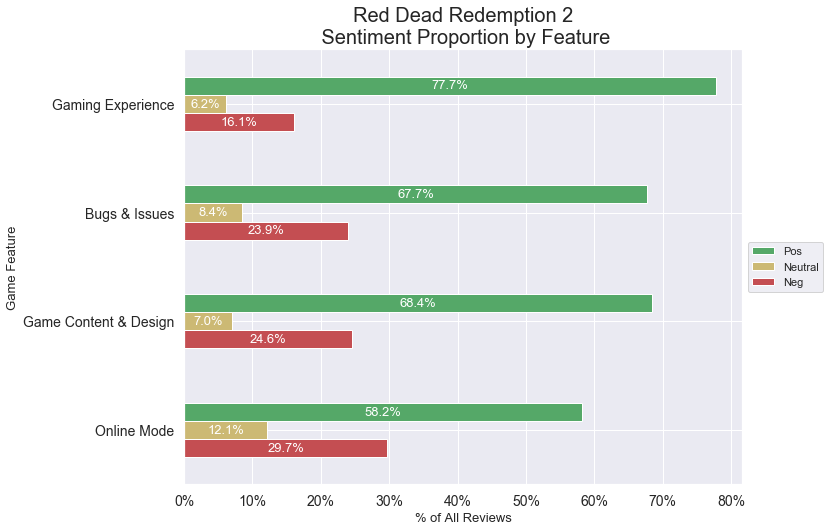

In [158]:
#generate final plot with less wordy title

ax = syntok_score_df_2.plot(kind='barh',figsize=(10,8),sort_columns=True,color=['g','y','r'],fontsize=14)

plt.gca().invert_yaxis() #display in order from top to bottom instead of the other way around

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('% of All Reviews',fontsize=13)
plt.ylabel('Game Feature',fontsize=13)
plt.title('Red Dead Redemption 2\n Sentiment Proportion by Feature',fontsize=20)
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width*100,3))+'%', xy=(left+width/2, bottom+height/2), #use round() on width before using str() to avoid having excessive decimal pts
                ha='center', va='center',fontsize=13,color='w')

# References

https://medium.com/@makcedward/nlp-pipeline-sentence-tokenization-part-6-86ed55b185e6

https://github.com/nuwapi/DoctorSnapshot/

https://github.com/fnl/syntok/blob/master/README.rst